In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import math
import pymap3d as pm
from scipy.spatial.transform import Rotation
from pathlib import Path
from utils import project_root
import matplotlib
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from matplotlib import pyplot
from scipy.stats._continuous_distns import _distn_names
import probscale
import seaborn
import pylab
import random
import copy

%matplotlib inline
# %matplotlib notebook

In [2]:
random.seed(0)
plt.rcParams["figure.figsize"] = (20,10)

# Global variables (extrinsic calibration)

In [3]:
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
R_b2i

array([[-3.6732051e-06, -1.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00, -3.6732051e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [4]:
rot_order = "xyz"

# Helper functions

In [5]:
def traj_RMSE(gt, est):
    e = gt-est
    se = e**2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    
    return rmse

In [6]:
# force two array to be of same size, given different timestamps
def same_size(a1, a1_t, a2, a2_t):
    # detect the biggest (length-wise) array and the smallest
    if len(a1_t) > len(a2_t):
        l_t = a1_t
        l_a = a1
        s_t = a2_t
        s_a = a2
    else:
        l_t = a2_t
        l_a = a2
        s_t = a1_t
        s_a = a1

    # keep the padded new small array, which will have the same length
    new_s_a = []
    # iterate over the small array
    for i in range(len(s_t)):
        # keeps latest position
        last_stop = 0
        # iterate over the long array from the last stopped position
        for j in range(last_stop, len(l_t)):
            # for every element that is bigger, append the last item
            if i != (len(s_t) - 1):
                if l_t[j] >= s_t[i] and l_t[j] < s_t[i+1]:
                    new_s_a.append(s_a[i])
                # else just break the loop cause we are in different time interval
                else:
                    last_stop = j
            else:
                if l_t[j] >= s_t[i]:
                    new_s_a.append(s_a[i])
                else:
                    last_stop = j

    # depending on which array we replaced (the smallest), return the arrays and the time array we kept
    if l_t is a1_t:
        return a1, np.array(new_s_a), l_t
    else:
        return np.array(new_s_a), a2, l_t


In [7]:
def cotan(x):
    return 1/np.tan(x)

In [8]:
# function to compare floats to 0, in case simple == fails
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [9]:
# function to return the index of the closest IMU reading to the given timestamp
def get_IMU_reading(time, imu_times):
    min_dt = 10000
    for idx, stamp in enumerate(imu_times):
        #print(stamp, time)
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

In [10]:
# function to remove all the radar readings that have very low range
def remove_low_range(vr, the, ra, range_thresh):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if ra[j] < range_thresh:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

In [11]:
# function to remove all the radar readings with 0 radial speed or radial speed < val
def remove_zero_radial(vr, the, ra, val=0):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if abs(vr[j]) <= val:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

In [12]:
# function to combine #n multiple radar scans
def multi_scans(r0, th0, vr0, t0, n):
    r1, th1, vr1, t1 = [], [], [], []
    
    # combine radial speed, azimuth angle and range
    print("Aggregating radial speed, azimuth angle and range...")
    j = 0
    while j < len(r0):
        tempr = r0[j]
        tempth = th0[j]
        tempvr = vr0[j]
        # don't go out of the list
        if j+n < len(t0):
            m = n
        else:
            m = len(t0) - j
            
        # add the next m elements to the new lists
        for k in range(1, m):
            tempr.extend(r0[j+k])
            tempth.extend(th0[j+k])
            tempvr.extend(vr0[j+k])
            
        r1.append(tempr)
        th1.append(tempth)
        vr1.append(tempvr)
        
        j+=n
        
    # combine time readings by taking the average
    print("Aggregating timestamps...")
    j = 0
    while j < len(t0):
        if j+n < len(t0):
            m = n
        else:
            m = len(t0) - j
        # add the average of the next m readings
        tempt = np.mean(t0[j:j+m])
        t1.append(tempt)
        
        j+=n
        
    return r1, th1, vr1, t1

In [13]:
# the first derivative of a rotation matrix
def dR(axis, x):
    if axis == 'z':
        ret = np.array([[-np.sin(x), -np.cos(x), 0],
                      [np.cos(x), -np.sin(x), 0],
                      [0, 0, 0]]).reshape(3,3)
    else:
        raise
        
        
    return(ret)

In [14]:
# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# Load data

## Radar data  (r_list, theta_list, psi_list, v_r_list) - "radar/radar_data"-> range, speed_radial, azimuth (theta), elevation (psi)

In [15]:
# loads azimuth and speed_radial readings from the ros2 bag "2021_10_26-16_14_27"
os.chdir(Path(project_root() / 'data/radar_pointclouds/raw'))

lines = []
# '2022-02-17.txt' includes only azimuth angles
# '2022-05-18.txt' includes azimuth and elevation angles 
# note: elevation doesn't add much, since the field of view is only [-7.5, ..., 7.5] degrees
with open('2022-05-18.txt') as f:
    lines = f.readlines()

# these lists will keep all the returns from the entire video
theta_list = []
psi_list = []
v_r_list = []
r_list = []

# these lists will keep the returns just for one frame of the video
sec_list = []
nsec_list = []
theta = [] # azimuth angle in !radians!
psi = [] # elevation angle in !radians!
v_r = [] # radial speed
r = [] # range

# iterate over the entire video
for line in lines:
    # check if we have a new scan
    if line[0:3] == "New":
        # if it is not the first, add the previous scan to the list of all the scans
        if theta and v_r:
            r_list.append(r)
            theta_list.append(theta)
            psi_list.append(psi)
            v_r_list.append(v_r)

        # reset the lists for this current frame
        r = []
        theta = []
        psi = []
        v_r = []

    elif line[0:3] == "Sec":
        sec_list.append(int(line[5:-1]))
    elif line[0:4] == "Nsec":
        nsec_list.append(int(line[6:-1]))
    elif line[0:1] == "r":
        r.append(float(line[2:-1]))
    elif line[0:1] == "a":
        theta.append(math.radians(float(line[2:-1])))
    elif line[0:1] == "b":
        psi.append(math.radians(float(line[2:-1])))
    elif line[0:3] == "v_r":
        v_r.append(float(line[4:-1]))

# append the last 2 items
r_list.append(r)
theta_list.append(theta)
psi_list.append(psi)
v_r_list.append(v_r)

In [16]:
print(len(r_list), len(theta_list), len(psi_list), len(v_r_list), len(sec_list), len(nsec_list))

1658 1658 1658 1658 1658 1658


In [17]:
temp = [i*1e-9 for i in nsec_list]
t_radar = [sum(x) for x in zip(sec_list, temp)]

## GPS data

### WGS84 (lattitude, longitude, altitude) - "/gps/fix"

In [18]:
os.chdir(Path(project_root() / 'data/topics'))

lines = []
with open('gps.txt') as f:
    lines = f.readlines()

In [19]:
lattitude = []
longitude = []
altitude = []
sec_gps = []
nsec_gps = []
count = 0
for line in lines:
    count += 1
    if line[4:7] == "sec":
        sec_gps.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_gps.append(int(line[13:-1]))
    elif line[0:3] == "lat":
        lattitude.append(float(line[10:-1]))
    elif line[0:3] == "lon":
        longitude.append(float(line[11:-1]))
    elif line[0:3] == "alt":
        altitude.append(float(line[10:-1]))

In [20]:
temp = [i*1e-9 for i in nsec_gps]
t_gps = [sum(x) for x in zip(sec_gps, temp)]
tt_gps = [x-t_gps[0] for x in t_gps]

### Positions (x_gps, y_gps, z_gps) - base_link frame

In [21]:
x_off = -0.01
y_off = 0
z_off = 2.13

In [22]:
lat_0 = lattitude[0]
lon_0 = longitude[0]
alt_0 = altitude[0]

x_gps = []
y_gps = []
z_gps = []
for i in range(len(lattitude)):
    # get [east, noth, up] w.r.t. an origin and assume it is [x, y, z]
    x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
    # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"??
    # I am not doing that, I consider it neglectable, as we are mainly moving in 2d
    x_gps.append(x_)
    y_gps.append(y_)
    z_gps.append(z_)

### Initial orientation

In [23]:
x_gps[40:50]

[0.010246436057356279,
 0.009040355965707368,
 0.01277396016783668,
 0.018300952729231445,
 0.024593543897349617,
 0.03404291822707218,
 0.03488193037116184,
 0.04945976670924634,
 0.06101715904873346,
 0.07805959329781789]

In [24]:
t1 = 42
t2 = 44
ori = 0
for i in range(t1, t2):
    ori += np.arctan2(x_gps[i] - x_gps[0], y_gps[i] - y_gps[0])
  
orientation_init = ori/(t2-t1)

In [25]:
orientation_init

0.44065848049271206

In [26]:
np.rad2deg(orientation_init)

25.247871138880317

### Velocities (v_x_gps, v_y_gps, v_z_gps) <- from the positions as dx/dt - base_link frame

In [27]:
v_x_gps = []
v_y_gps = []
v_z_gps = []
for i in range(len(x_gps)):  
    # in the first iteration, the vehicle is stopped
    if i==0:
        v_x, v_y, v_z = 0, 0, 0
    # in the rest, get velocities from kinematics
    else:
        # get dt in seconds
        dt = t_gps[i] - t_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
        
        # now depending on the distance travelled in the heading direction, we can get dx, dy
        dx = x_gps[i] - x_gps[i-1]
        dy = y_gps[i] - y_gps[i-1]
        dz = z_gps[i] - z_gps[i-1]
        v_x = dx/dt
        v_y = dy/dt
        v_z = dz/dt
        
    v_x_gps.append(v_x)
    v_y_gps.append(v_y)
    v_z_gps.append(v_z)

### Velocities (v_x_gps_topic, v_y_gps_topic, v_z_gps_topic) - "/gps/vel" - gps frame

In [28]:
os.chdir(Path(project_root() / 'data/topics'))
lines = []
with open('gps_vel.txt') as f:
    lines = f.readlines()

In [29]:
v_x_gps_topic = []
v_y_gps_topic = []
v_z_gps_topic = []
sec_gps_vel = []
nsec_gps_vel = []
count = 0
tip = 0
for line in lines:
    count += 1
    if len(line) < 5:
        continue
    elif line[4:7] == "sec":
        sec_gps_vel.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_gps_vel.append(int(line[13:-1]))
    elif line[4] == "x":
        if tip % 2 == 0:
            v_x_gps_topic.append(float(line[7:-1]))
    elif line[4] == "y":
        if tip%2 == 0:
            v_y_gps_topic.append(float(line[7:-1]))
    elif line[4] == "z":
        if tip%2 == 0:
            v_z_gps_topic.append(float(line[7:-1]))
        tip+=1

In [30]:
temp = [i*1e-9 for i in nsec_gps_vel]
t_gps_topic = [sum(x) for x in zip(sec_gps_vel, temp)]
tt_gps_topic = [x-t_gps_topic[0] for x in t_gps_topic]

## IMU data (orientation, ang_vel, lin_acc) - "/ouster/imu"

### Load IMU data

In [31]:
os.chdir(Path(project_root() / 'data/topics'))
lines = []
with open('imu.txt') as f:
    lines = f.readlines()

In [32]:
ang_vel = [] # [w_x, w_y, w_z]
ang_vel_e = []
lin_acc = [] # [x_ddot, y_ddot, z_ddot]
sec_imu = []
nsec_imu = []
count = 0

for idx, line in enumerate(lines):
    count += 1
    if line[4:7] == "sec":
        sec_imu.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_imu.append(int(line[13:-1]))
    elif line[0:-1] == "orientation:":
        qx = float(lines[idx+1][5:-1])
        qy = float(lines[idx+2][5:-1])
        qz = float(lines[idx+3][5:-1])
        qw = float(lines[idx+4][5:-1])       
    elif line[0:-1] == "angular_velocity:":
        w_x = float(lines[idx+1][5:-1])
        w_y = float(lines[idx+2][5:-1])
        w_z = float(lines[idx+3][5:-1])
        ang_vel.append([w_x, w_y, w_z])
    elif line[0:-1] == "linear_acceleration:":
        a_x = float(lines[idx+1][5:-1])
        a_y = float(lines[idx+2][5:-1])
        a_z = float(lines[idx+3][5:-1])
        lin_acc.append([a_x, a_y, a_z])

In [33]:
# save the angular velocity in degrees/sec as well
ang_vel_e = []
for temp in ang_vel:
    a0 = math.degrees(temp[0])
    a1 = math.degrees(temp[1])
    a2 = math.degrees(temp[2])
    
    ang_vel_e.append([a0, a1, a2])

In [34]:
temp = [i*1e-9 for i in nsec_imu]
t_imu = [sum(x) for x in zip(sec_imu, temp)]
tt_imu = [x-t_imu[0] for x in t_imu]

### Find IMU bias

In [35]:
m = 300
t = np.arange(m)

[-0.01907755  0.01299578 -0.00510084]


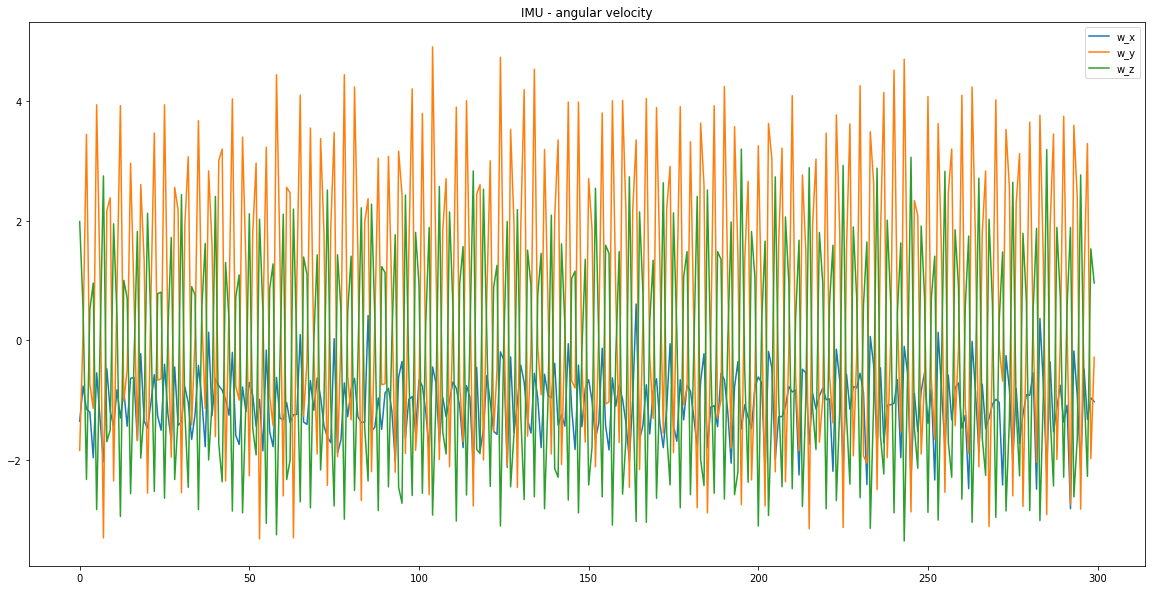

In [36]:
static_ang_vel = np.array(ang_vel)[0:m,:]
ang_vel_imu_bias = np.mean(np.array(static_ang_vel), axis=0)
print(ang_vel_imu_bias)

plt.plot(t, np.array(ang_vel_e)[0:m,0], label="w_x")
plt.plot(t, np.array(ang_vel_e)[0:m,1], label="w_y")
plt.plot(t, np.array(ang_vel_e)[0:m,2], label="w_z")
plt.title("IMU - angular velocity")
plt.legend()
plt.show()

[ 0.10895214 -0.80556905  9.71302873]


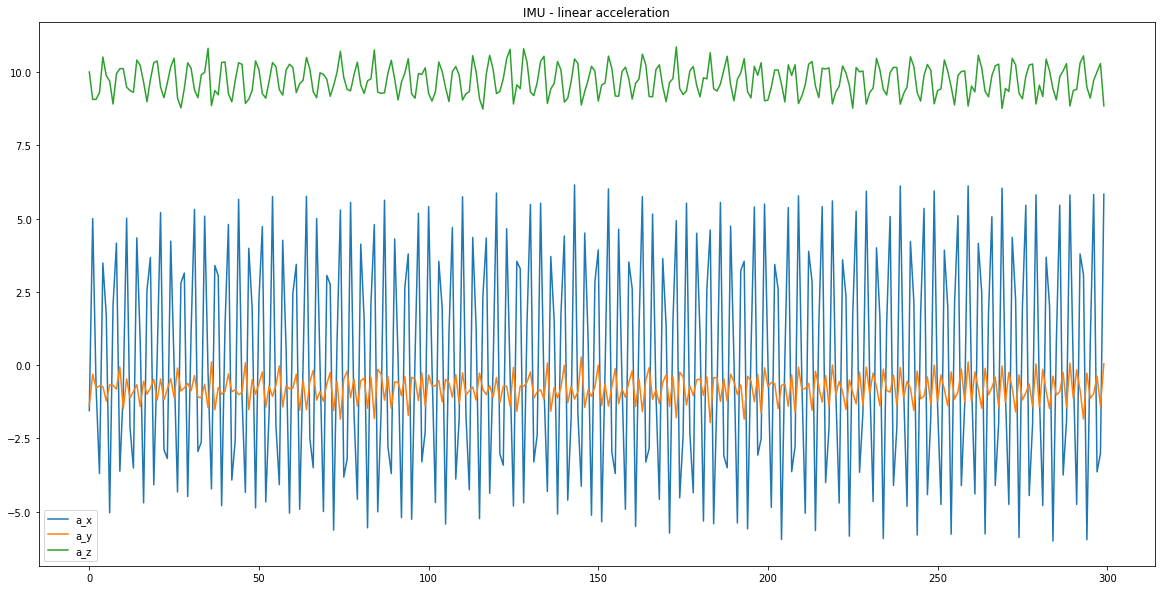

In [37]:
static_lin_acc = np.array(lin_acc)[0:m,:]
lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
print(lin_acc_imu_bias)

plt.plot(t, np.array(lin_acc)[0:m,0], label="a_x")
plt.plot(t, np.array(lin_acc)[0:m,1], label="a_y")
plt.plot(t, np.array(lin_acc)[0:m,2], label="a_z")
plt.title("IMU - linear acceleration")
plt.legend()
plt.show()

### Remove IMU bias

In [38]:
for i in range(len(ang_vel)):
    ang_vel[i][0] = ang_vel[i][0] - ang_vel_imu_bias[0]
    ang_vel[i][1] = ang_vel[i][1] - ang_vel_imu_bias[1]
    ang_vel[i][2] = ang_vel[i][2] - ang_vel_imu_bias[2]

ang_vel_e = []
for [x,y,z] in ang_vel:
    ang_vel_e.append([np.rad2deg(x), np.rad2deg(y), np.rad2deg(z)])
ang_vel_e = np.array(ang_vel_e)

for i in range(len(lin_acc)):
    lin_acc[i][0] = lin_acc[i][0] - lin_acc_imu_bias[0]
    lin_acc[i][1] = lin_acc[i][1] - lin_acc_imu_bias[1]
    lin_acc[i][2] = lin_acc[i][2] - lin_acc_imu_bias[2]

### Plot IMU data for the entire dataset

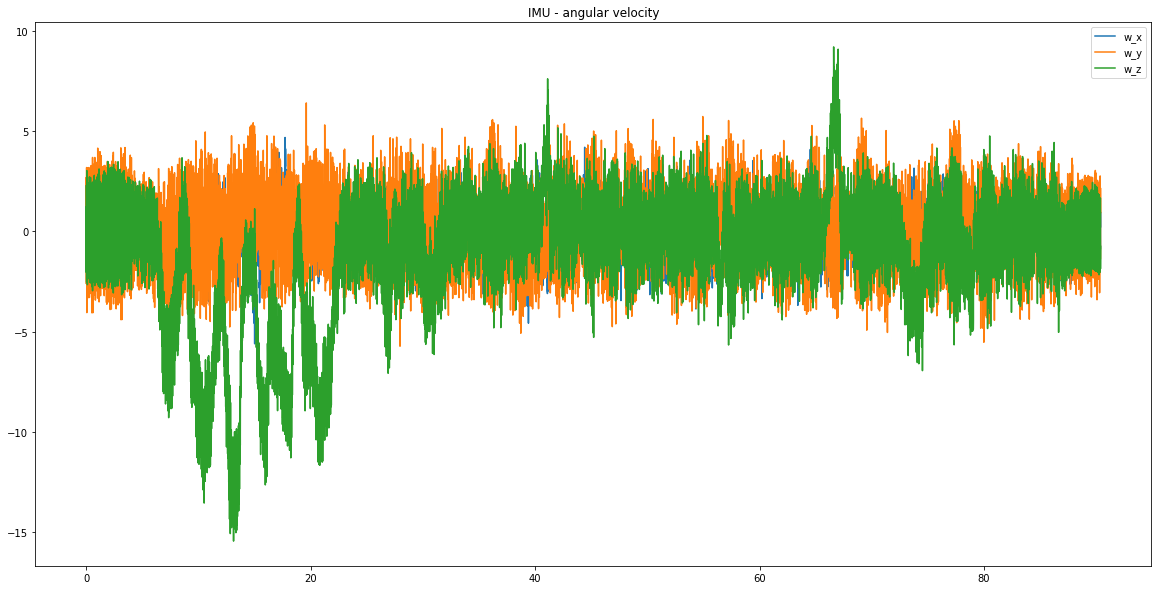

In [39]:
plt.plot(tt_imu, ang_vel_e[:,0], label="w_x")
plt.plot(tt_imu, ang_vel_e[:,1], label="w_y")
plt.plot(tt_imu, ang_vel_e[:,2], label="w_z")
plt.title("IMU - angular velocity")
plt.legend()
plt.show()

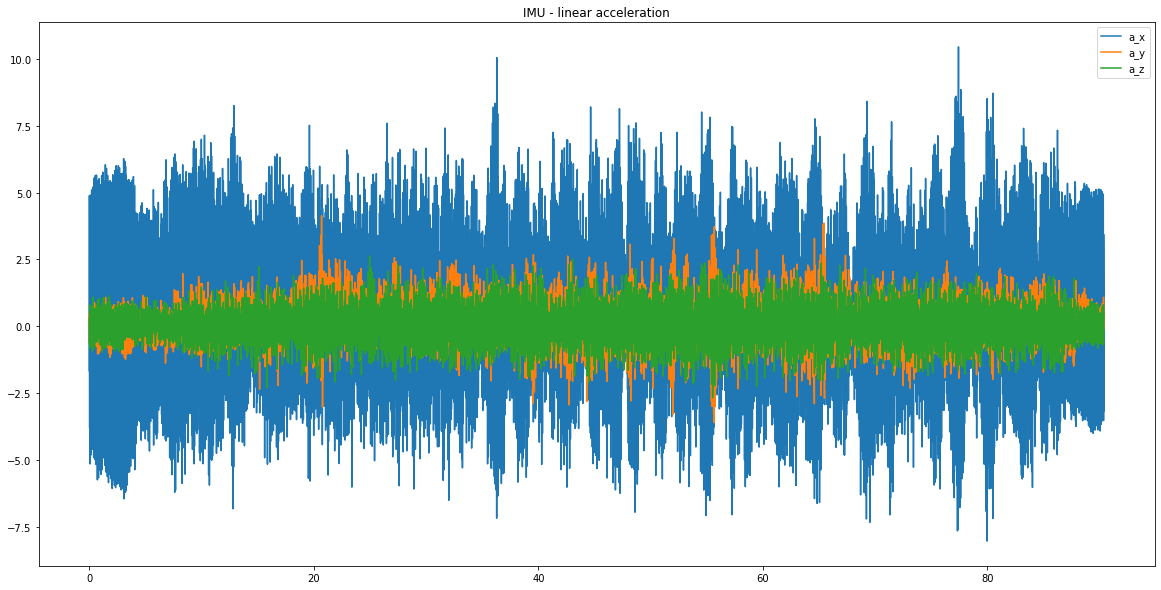

In [40]:
plt.plot(tt_imu, np.array(lin_acc)[:,0], label="a_x")
plt.plot(tt_imu, np.array(lin_acc)[:,1], label="a_y")
plt.plot(tt_imu, np.array(lin_acc)[:,2], label="a_z")
plt.title("IMU - linear acceleration")
plt.legend()
plt.show()

# Radar Odometry

## 1. Ransac

In [41]:
def Ransac(theta, psi, v_r, error_threshold, max_iter, stop_e, stop_in, ransac_flag=True, criteria="num_inliers"):    
    num_radar_points = len(theta)
    # check if we do not have enough non-zero radial_speed returns
    c1_ = np.count_nonzero(v_r) < round(num_radar_points/8)
    c2_ = np.count_nonzero(v_r) < 5
    if c2_:
        return num_radar_points, False, [], [], 0, 100, 100, None
        
    i = 0
    max_inliers = 0
    min_e = 9999
    best_inliers = []
    best_outliers = []
    v_s = None
    alpha = None
    
    # if the criteria is error %, we need the sum of all the absolute radial speeds
    sum_vr = 0
    for j in range(num_radar_points):
        sum_vr += abs(v_r[j])
    
    # Ransac loop
    while (True):
        # exit criteria
        if i>0:
            if cond or i>=max_iter:
                break
        
        # check if we will use 2 points or a subsample during ransac
        if (not ransac_flag):
            # generate random number between 0 and *# of radar points*-1
            p1 = randrange(num_radar_points)
            p2 = randrange(num_radar_points)
            while (p2==p1):
                p2 = randrange(num_radar_points)

            # Analytical approach (solving the 2x2 system)
#             # just azimuth
#             num = (np.cos(theta[p1])*v_r[p2]) - (np.cos(theta[p2])*v_r[p1])
#             denom = (np.cos(theta[p1])*np.sin(theta[p2])) - (np.sin(theta[p1])*np.cos(theta[p2]))
#             v_y = num/denom
#             v_x = ( v_r[p2] - (np.sin(theta[p2])*v_y) ) / np.cos(theta[p2])
            # azimuth + elevation
            num = (np.cos(psi[j])*np.cos(theta[p1])*v_r[p2]) - (np.cos(psi[j])*np.cos(theta[p2])*v_r[p1])
            denom = (np.cos(psi[j])*np.cos(theta[p1])*np.cos(psi[j])*np.sin(theta[p2])) - (np.cos(psi[j])*np.sin(theta[p1])*np.cos(psi[j])*np.cos(theta[p2]))
            v_y = num/denom
            v_x = ( v_r[p2] - (np.cos(psi[j])*np.sin(theta[p2])*v_y) ) / np.cos(psi[j])*np.cos(theta[p2])
            
            # we did not implement LSQ, so we dont have a residual error
            SSR = None
        else:
            # generate random subsample of semi-random size m >= 2
            subsample = []
            n_ = 6
            m = round(num_radar_points/n_)
            while m < 2:
                n_ -= 1
                m = round(num_radar_points/n_)
            for j in range(m):
                # generate random indeces in [0, num_radar_points)
                p = randrange(0, num_radar_points)
                # no duplicates!!
                while (p in subsample):
                    p = randrange(0, num_radar_points)
                subsample.append(p)
    
            # initialize matrix A and B for the LSQ problem
            A = []
            b = []

            # iterate over the subsample
            for j in subsample:
                # fill the A and b matrix
        #         A1 = np.cos(theta[j]) # azimuth
        #         A2 = np.sin(theta[j]) # azimuth
                A1 = np.cos(psi[j])*np.cos(theta[j]) # elevation + azimuth
                A2 = np.cos(psi[j])*np.sin(theta[j]) # elevation + azimuth
                A.append([A1, A2])
                b.append(v_r[j])

            # solve LSQ   
            sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
            # x
            v_x = sol[0][0]
            v_y = sol[0][1]
            # sum of squared residuals
            SSR = sol[1]

        # now find the sensor velocity and heading
        if v_x != 0: # avoid division by 0 (non-moving vehicle)
            alpha = np.arctan2(v_y,v_x)
            v_s = -v_x/np.cos(alpha)

            # calculate the error of the current fit and the number of outliers/inliers
            sum_e = 0
            current_inliers = [] # index of all the inlier radar readings
            current_outliers = [] # index of all the outlier radar readings
            for j in range(num_radar_points):
                # measure the error between the radial speed and the sensor velocity
#                 e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) # azimuth only
                e = abs(v_r[j] - (v_x*np.cos(psi[j])*np.cos(theta[j]) + v_y*np.cos(psi[j])*np.sin(theta[j]))) 

                # if the current radar reading has a small error, compared to the velocity profile of 
                # the randomly chosen subsample/2 points, it is an inlier
                if ( e < (error_threshold*abs(v_r[j])) ):
                    current_inliers.append(j)
                else:
                    current_outliers.append(j)
                # count the accumulated error to determine best fit
                sum_e += e

            # keep the best fit in terms of minimum error and maximum inliers (this is the same most of the times)
            if (len(current_inliers) > max_inliers):
                max_inliers = len(current_inliers)
                min_e = sum_e
                if criteria == "num_inliers":
                    # calculate the % of inliers and
                    pct_e = 100*min_e/sum_vr
                    pct_inl = 100*max_inliers/num_radar_points
                    # keep the inliers and outliers and SSR
                    best_inliers = current_inliers
                    best_outliers = current_outliers
                    best_SSR = SSR
            if (sum_e < min_e):
                min_e = sum_e
                max_inliers = len(current_inliers)
                if criteria=="error":
                    pct_e = 100*min_e/sum_vr
                    pct_inl = 100*max_inliers/num_radar_points
                    best_inliers = current_inliers
                    best_outliers = current_outliers
                    best_SSR = SSR

        i+=1
        
        # determine which is the first condition to break the loop, based on the criteria given
        if criteria=="error":
            cond = min_e < stop_e*sum_vr # the minimum error being less than (stop_e)% of the sum of radial velocities
        else:
            cond = max_inliers > round(stop_in*num_radar_points) # the max inliers being more than (stop_in)% of the points 
            
        # give proper warning if ransac did not converge at max_iter
        if (i == max_iter):
            print(f"Warning! Ransac did not converge but stopped at {max_iter} iterations.")
            
            # depending on criteria, give diagnostic message
            if criteria == "error":
                print(f"Minimum error %: {pct_e}.")
            else:     
                print(f"% of inliers: {pct_inl}.")

    return num_radar_points, True, best_inliers, best_outliers, i, pct_e, pct_inl, best_SSR

## 2. LSQ

In [42]:
# perform LSQ to get the sensor velocity and direction based on the inliers from Ransac,  
# the azimuth and the radial_speed radar readings
def inliers_LSQ(best_inliers, theta, psi, v_r, error_threshold):
    # print()"Step 2: LSQ on the inlier set.")
    # initialize the A matrix and b vector for the least squares prloblem
    A = []
    b = []

    # iterate over all the inliers
    for j in best_inliers:
        # fill the A and b matrix
#         A1 = np.cos(theta[j]) # azimuth
#         A2 = np.sin(theta[j]) # azimuth
        A1 = np.cos(psi[j])*np.cos(theta[j]) # elevation + azimuth
        A2 = np.cos(psi[j])*np.sin(theta[j]) # elevation + azimuth
        A.append([A1, A2])
        b.append(v_r[j])

    # solve the LSQ problem
    sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)

    # the solution is going to be used to extract the sensor velocity and heading direction
    # v_x and v_y are the radar sensor linear velocities in the x,y directions
    v_x = sol[0][0]
    v_y = sol[0][1]
    # sum of squared residuals
    SSR = sol[1]

    # calculate sensor velocity and direction
    alpha = np.arctan2(v_y,v_x)
    v_s = -v_x/np.cos(alpha)

    # get new, improved inliers
    final_inliers = []
    final_outliers = []
    sum_e = 0
    for j in range(len(v_r)):
        # measure the error between the radial speed and the sensor velocity
#         e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) # azimuth only
        e = abs(v_r[j] - (v_x*np.cos(psi[j])*np.cos(theta[j]) + v_y*np.cos(psi[j])*np.sin(theta[j]))) 
        sum_e += e

        # if the current radar reading has a small error, it is an inlier
        if (e<error_threshold):
            final_inliers.append(j)
        else:
            final_outliers.append(j)
            
    # determine which is the first condition to break the loop, based on the criteria given
    pct_e = 100*sum_e/sum([abs(_) for _ in v_r])
    pct_inl = 100*len(final_inliers)/len(v_r)
    
    return v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e, pct_inl, SSR[0]

## 3.Ego-motion estimation

In [43]:
def ego_motion(v_s, alpha, b_, l_, beta_):
    # print()"Step 3: Ego-motion estimation.")
    # if the vehicle is moving, proceed to find the sensor and vehicle velocity and yaw rates
    if (v_s != 0):
        # now calculate the vehicle velocity and yaw rate based on the Ackerman condition
        v = ( np.cos(alpha + beta_) - ((b_/l_)*np.sin(alpha+beta_)) ) * v_s
        omega = (np.sin(alpha+beta_)/l_) * v_s
    else:
        print("\t\t\t WTF!!Non-moving vehicle!!")
        v = 0
        omega = 0
    
    return v, omega

# Apply the algorithm on our dataset

In [44]:
# iterate over the entire video
v_r_used = []
theta_used = []
psi_used = []
v_list = []
omega_list = []
t_list = []
inlier_list = []
outlier_list = []
v_x_list = []
v_y_list = []
alpha_list = []

# keep the performance of ransac
num_radar_pts_list = []
e_pct_ransac = []
e_pct_lsq = []
inl_pct_ransac = []
inl_pct_lsq = []

# keep the performance of Least Squares
ssr_ransac_list = []
ssr_lsq_list = []

# keep the lsq timestamps
t_lsq = []

# tuning
# Ransac
# use sub-samples flag
ransac_flag = False
# stoppage criteria
crit = "num_inliers"
max_iter = 50 # maximum iterations
stop_error = 0.05 # total error %
stop_inl = 0.9 # % of inliers
# percentage of error allowed to be considered inlier
error_threshold = 0.1

# Filtering
radial_speed_filtering = False
radial_threshold = 0 # removing all 0 radial speed returns
range_filtering = False
range_threshold = 1 # meters
velocity_filtering = False
velocity_thresholod = 0.5 # percentage of velocity deviation that is allowed between iterations

# LSQ criteria
lsq_inlier_pct_thresh = 0.5 # % of Ransac inliers required to accept ransac-LSQ result
lsq_inlier_num_thresh = 5 # number of Ransac inliers required to accept ransac-LSQ result

# multi-scans aggregation
num_scans = 2
#r_list, theta_list, v_r_list, t_radar = multi_scans(r_list, theta_list, v_r_list, t_radar, num_scans)
tt_radar = [x-t_radar[0] for x in t_radar]

In [45]:
for i in range(len(theta_list)):
    print(f"\n\tvideo frame: {i}")
    print(f"At time: {tt_radar[i]} seconds.")
    # extract the azimuth angles and radial speeds for one specific radar reading
    theta = theta_list[i]
    psi = psi_list[i]
    v_r = v_r_list[i]
    r = r_list[i]
    print(f"# of radar readings: {len(theta)}")

    # filter based on radial_speeds returns. There should almost never be 0 radial speeds. If there are, we are probably stationary or sth is wrong
    if radial_speed_filtering:
        v_r, theta, r, remove_idxs = remove_zero_radial(v_r, theta, r, radial_threshold)
        print(f"# of radar readings after radial speed filtering: {len(theta)}. Removed {len(remove_idxs)} points!")

    # filter based on range, to avoid objects that are too close to the radar sensor and block the view
    if range_filtering:
        v_r, theta, r, remove_idxs = remove_low_range(v_r, theta, r, range_threshold)
        print(f"# of radar readings after range filtering: {len(theta)}. Removed {len(remove_idxs)} points!")
    
    # step 1 - ransac
    # if false, ransac is applied with 2 random pooints, otherwise, it uses a subsample
    # of the total radar_points
    # criteria can either be "error" or "num_inliers"
    print("Step 1. Ransac...")
    num_radar_pts, retval, inliers, outliers, it, pct_e_ransac, pct_inl_ransac, SSR = Ransac(theta, psi, v_r, 
                                                                         error_threshold, max_iter,
                                                                         stop_error, stop_inl,
                                                                         ransac_flag=True, criteria=crit)
    ssr_ransac_list.append(SSR)
    num_radar_pts_list.append(num_radar_pts)
    print(f"\t# of inliers: {len(inliers)}")
    print(f"\t# of iterations: {it}")
    print(f"\tSSR: {SSR}")

    # if we had enough radial speed returns
    if retval:
        # if ransac succedeed, go to the next steps
        if len(inliers) < lsq_inlier_pct_thresh*len(theta) or len(inliers) < lsq_inlier_num_thresh:
            print("Warning! Not enough inliers!!")
            final_inliers = []
            final_outliers = []
            if v_list:
                v = v_list[-1]
                omega = omega_list[-1]
                v_x = v_x_list[-1]
                v_y = v_y_list[-1]
                alpha = alpha_list[-1]
                pct_e_ransac = e_pct_ransac[-1]
                pct_e_lsq = e_pct_lsq[-1]
                pct_inl_ransac = inl_pct_ransac[-1]
                pct_inl_lsq = inl_pct_lsq[-1]
            else:
                v, omega, v_x, v_y,  = 0, 0, 0, 0
                pct_e_ransac, pct_e_lsq, pct_inl_ransac, pct_inl_lsq = 100, 100, 100, 100
        else:
            # step 2 - LSQ
            print("Step 2. LSQ...")
            [v_x, v_y, v_s, alpha, 
            final_inliers, final_outliers, 
            pct_e_lsq, pct_inl_lsq, SSR] = inliers_LSQ(inliers, theta, psi, v_r, error_threshold)
            t_lsq.append(tt_radar[i])
            ssr_lsq_list.append(SSR)
            print(f"\tLSQ SSR: {SSR}")
            print(f"\tLSQ # of optimized inliers: {len(final_inliers)}")
            print(f"\tLSQ Error: {pct_e_lsq} %")
            print(f"\tSensor velocity: {v_s} (m/sec)\n\tSensor direction: {alpha} (rad)")

            # step 3 - ego-motion
            l_ = 0.915; # x_s
            b_ = 0; # y_s
            beta_ = 0; # a_s
            print("Step 3. Ego-motion...")
            v, omega = ego_motion(v_s, alpha, b_, l_, beta_)
            print(f"\tVehicle velocity: {v} (m/s)\n\tVehicle yaw rate: {omega} (rad/sec)")

            # reject fits that indicate the problem of the largest group being moving targets
            if velocity_filtering:
                if v_list:
                    v_diff = abs(v_list[-1] - v)
                    if v_diff > abs(velocity_thresholod*v_list[-1]) and v_list[-1] != 0:
                        print(f"Danger!! Large velocity deviation: {v_list[-1] - v} m/sec! Skipping this iteration...")
                        v = v_list[-1]
                        omega = omega_list[-1]
                        v_x = v_x_list[-1]
                        v_y = v_y_list[-1]
            
        # keep all the data
        v_r_used.append(v_r) # radial speeds of current frame
        theta_used.append(theta) # azimuth angles of current frame
        psi_used.append(psi) # elevation angles of current frame
        
#         inlier_list.append(final_inliers) # final inliers
#         outlier_list.append(final_outliers) # final outliers
        inlier_list.append(inliers) # final inliers
        outlier_list.append(outliers) # final outliers
        
        e_pct_ransac.append(pct_e_ransac) # ransac fit error
        e_pct_lsq.append(pct_e_lsq) # lsq fit error
        inl_pct_ransac.append(pct_inl_ransac) # ransac fit inlier pct
        inl_pct_lsq.append(pct_inl_lsq) # lsq fit inlier pct
        
        v_list.append(v) # vehicle linear vel
        omega_list.append(omega) # vehicle angular vel
        t_list.append(tt_radar[i]) # radar timestamp
        v_x_list.append(v_x) # sensor linear velocity on its x-axis
        v_y_list.append(v_y) # sensor linear velocity on its y-axis
        alpha_list.append(alpha) # sensor orientation
    else:
        # if not enough radial speed returns
        print("Not enough non-zero radial_speed returns!")

        # keep all the data
        v_r_used.append(v_r) # radial speeds of current frame
        theta_used.append(theta) # azimuth angles of current frame
        psi_used.append(psi) # elevation angles of current frame
        v_list.append(0) # vehicle linear vel
        omega_list.append(0) # vehicle angular vel
        t_list.append(tt_radar[i]) # radar timestamp
#         inlier_list.append([]) # final inliers
#         outlier_list.append([]) # final outliers
        inlier_list.append(inliers) # final inliers
        outlier_list.append(outliers) # final outliers
        e_pct_ransac.append(100) # ransac fit error
        e_pct_lsq.append(100) # lsq fit error
        inl_pct_ransac.append(100) # ransac fit inlier pct
        inl_pct_lsq.append(100) # lsq fit inlier pct
        v_x_list.append(0) # sensor linear velocity on its x-axis
        v_y_list.append(0) # sensor linear velocity on its y-axis
        if alpha_list:
            alpha_list.append(alpha_list[-1]) # sensor orientation
        else:
            alpha_list.append(0)


	video frame: 0
At time: 0.0 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns!

	video frame: 1
At time: 0.05591750144958496 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns!

	video frame: 2
At time: 0.1108853816986084 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns!

	video frame: 3
At time: 0.1658315658569336 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns!

	video frame: 4
At time: 0.22082901000976562 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns!

	video frame: 5
At time: 0.27563977241516113 seconds.
# of radar readings: 28
Step

% of inliers: 58.064516129032256.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00050395]
Step 2. LSQ...
	LSQ SSR: 0.0004295101069766581
	LSQ # of optimized inliers: 31
	LSQ Error: 14.307130474305032 %
	Sensor velocity: -0.12708419590368578 (m/sec)
	Sensor direction: -2.9402732851665707 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.12451755352115154 (m/s)
	Vehicle yaw rate: 0.027772719948839716 (rad/sec)

	video frame: 97
At time: 5.338225603103638 seconds.
# of radar readings: 22
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 63.63636363636363.
	# of inliers: 14
	# of iterations: 50
	SSR: [0.00026676]
Step 2. LSQ...
	LSQ SSR: 0.0002992911456266632
	LSQ # of optimized inliers: 22
	LSQ Error: 12.672299288152162 %
	Sensor velocity: -0.13218648002367572 (m/sec)
	Sensor direction: 3.1293825739836816 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.1321766265664067 (m/s)
	Vehicle yaw rate: -0.0017638987321408964 (rad/sec)

	video frame: 9

% of inliers: 60.714285714285715.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.00071361]
Step 2. LSQ...
	LSQ SSR: 0.002545858367022915
	LSQ # of optimized inliers: 24
	LSQ Error: 15.613255360343718 %
	Sensor velocity: -0.243732063820844 (m/sec)
	Sensor direction: 3.115243538534618 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.2436474600712556 (m/s)
	Vehicle yaw rate: -0.007017902838334662 (rad/sec)

	video frame: 123
At time: 6.769256591796875 seconds.
# of radar readings: 23
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.26086956521739.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00048201]
Step 2. LSQ...
	LSQ SSR: 0.002417236223198542
	LSQ # of optimized inliers: 23
	LSQ Error: 10.43631781611219 %
	Sensor velocity: -0.22087473137073355 (m/sec)
	Sensor direction: 3.10072461267547 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.22069030491066366 (m/s)
	Vehicle yaw rate: -0.00986251916504179 (rad/sec)

	video frame: 124
At tim

	LSQ Error: 14.047238051121974 %
	Sensor velocity: -0.16465266614815627 (m/sec)
	Sensor direction: 2.9077027634291555 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.1601695401266189 (m/s)
	Vehicle yaw rate: -0.04170539467318249 (rad/sec)

	video frame: 147
At time: 8.090632438659668 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 53.84615384615385.
	# of inliers: 14
	# of iterations: 50
	SSR: [0.00068313]
Step 2. LSQ...
	LSQ SSR: 0.0006944809108652117
	LSQ # of optimized inliers: 25
	LSQ Error: 15.266664618964985 %
	Sensor velocity: -0.17428753071201739 (m/sec)
	Sensor direction: 2.9972386966617344 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.1724747744191571 (m/s)
	Vehicle yaw rate: -0.027400882937279825 (rad/sec)

	video frame: 148
At time: 8.145555257797241 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 53.846153846153

% of inliers: 79.16666666666667.
	# of inliers: 19
	# of iterations: 50
	SSR: [8.6293713e-05]
Step 2. LSQ...
	LSQ SSR: 0.0025630043030056724
	LSQ # of optimized inliers: 24
	LSQ Error: 9.640878877327394 %
	Sensor velocity: -0.2652506264351828 (m/sec)
	Sensor direction: -3.133184860909696 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.26524125107734653 (m/s)
	Vehicle yaw rate: 0.0024373180326951265 (rad/sec)

	video frame: 169
At time: 9.301975011825562 seconds.
# of radar readings: 20
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 15
	# of iterations: 50
	SSR: [0.00088214]
Step 2. LSQ...
	LSQ SSR: 0.0033782499719006817
	LSQ # of optimized inliers: 19
	LSQ Error: 11.168814655593003 %
	Sensor velocity: -0.2773326949231454 (m/sec)
	Sensor direction: -3.1276739730083074 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.2773058315712222 (m/s)
	Vehicle yaw rate: 0.0042185579896118165 (rad/sec)

	video frame: 170
At time: 9

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.86206896551724.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.00512883]
Step 2. LSQ...
	LSQ SSR: 0.005346928642483313
	LSQ # of optimized inliers: 27
	LSQ Error: 9.686078304531243 %
	Sensor velocity: -0.348555739882149 (m/sec)
	Sensor direction: 3.0204070457876657 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.34599943431020536 (m/s)
	Vehicle yaw rate: -0.046050957521600024 (rad/sec)

	video frame: 192
At time: 10.567199468612671 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.51724137931035.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.00024415]
Step 2. LSQ...
	LSQ SSR: 0.0018851093423896382
	LSQ # of optimized inliers: 27
	LSQ Error: 8.919685485033884 %
	Sensor velocity: -0.36829987415320214 (m/sec)
	Sensor direction: 2.842813899264934 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.35198296675028373 (m/s)
	Vehicle 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.91304347826087.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.00015464]
Step 2. LSQ...
	LSQ SSR: 0.005957000015753823
	LSQ # of optimized inliers: 21
	LSQ Error: 12.745589319652153 %
	Sensor velocity: -0.3774048874364944 (m/sec)
	Sensor direction: 2.7876279268085797 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.35400798743003126 (m/s)
	Vehicle yaw rate: -0.14296817250959157 (rad/sec)

	video frame: 216
At time: 11.887606382369995 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.92307692307692.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.0001164]
Step 2. LSQ...
	LSQ SSR: 0.003647042504673754
	LSQ # of optimized inliers: 24
	LSQ Error: 10.585893586699255 %
	Sensor velocity: -0.3673965364020847 (m/sec)
	Sensor direction: 2.9444516815650714 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3602802758972376 (m/s)
	Vehicle y

At time: 13.428475856781006 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.14285714285714.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00146647]
Step 2. LSQ...
	LSQ SSR: 0.008807826523588006
	LSQ # of optimized inliers: 26
	LSQ Error: 9.62713322004148 %
	Sensor velocity: -0.3796341243148426 (m/sec)
	Sensor direction: 2.9858980482852044 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3750420924217721 (m/s)
	Vehicle yaw rate: -0.06433713028770698 (rad/sec)

	video frame: 245
At time: 13.483409643173218 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00088578]
Step 2. LSQ...
	LSQ SSR: 0.004779399161899388
	LSQ # of optimized inliers: 24
	LSQ Error: 7.812416289256265 %
	Sensor velocity: -0.39497420217563173 (m/sec)
	Sensor direction: 2.9000894269286563 (rad)

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.57142857142857.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00053221]
Step 2. LSQ...
	LSQ SSR: 0.008178565928814285
	LSQ # of optimized inliers: 32
	LSQ Error: 9.079549722143142 %
	Sensor velocity: -0.40759086039124814 (m/sec)
	Sensor direction: 2.710041541602661 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3702221327259056 (m/s)
	Vehicle yaw rate: -0.18632479768684446 (rad/sec)

	video frame: 267
At time: 14.695003509521484 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00207106]
Step 2. LSQ...
	LSQ SSR: 0.006729252987901382
	LSQ # of optimized inliers: 31
	LSQ Error: 11.479341530359383 %
	Sensor velocity: -0.3760665666632506 (m/sec)
	Sensor direction: 2.8730277156655375 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.36258558810957897 (m/s)
	Vehicle yaw rate: -0.1

	# of inliers: 33
	# of iterations: 50
	SSR: [0.00229598]
Step 2. LSQ...
	LSQ SSR: 0.009700956926608556
	LSQ # of optimized inliers: 35
	LSQ Error: 8.511855940673964 %
	Sensor velocity: -0.5351918958330806 (m/sec)
	Sensor direction: 3.0024937908778213 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.530022660158403 (m/s)
	Vehicle yaw rate: -0.08109808862065415 (rad/sec)

	video frame: 291
At time: 16.01632308959961 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00095434]
Step 2. LSQ...
	LSQ SSR: 0.007035916943160721
	LSQ # of optimized inliers: 24
	LSQ Error: 13.139374672188195 %
	Sensor velocity: -0.5295940809212806 (m/sec)
	Sensor direction: 3.0153395317326144 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5253788592420666 (m/s)
	Vehicle yaw rate: -0.07288023689540202 (rad/sec)

	video frame: 292
At time: 16.071216583251953 seconds.
# of radar readi

Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.3103448275862.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00150056]
Step 2. LSQ...
	LSQ SSR: 0.005987639290040955
	LSQ # of optimized inliers: 26
	LSQ Error: 9.627539508910557 %
	Sensor velocity: -0.4065658390816343 (m/sec)
	Sensor direction: 2.9626536670430754 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.40007423963455496 (m/s)
	Vehicle yaw rate: -0.07908509879847525 (rad/sec)

	video frame: 315
At time: 17.336601495742798 seconds.
# of radar readings: 24
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00043031]
Step 2. LSQ...
	LSQ SSR: 0.004122432882814224
	LSQ # of optimized inliers: 23
	LSQ Error: 9.573374139170776 %
	Sensor velocity: -0.3852302010996353 (m/sec)
	Sensor direction: 2.937783536316966 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.37725698176902 (m/

At time: 18.547284364700317 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.6470588235294.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00021854]
Step 2. LSQ...
	LSQ SSR: 0.0029872951070350744
	LSQ # of optimized inliers: 27
	LSQ Error: 15.29014635875677 %
	Sensor velocity: -0.31939650096230465 (m/sec)
	Sensor direction: 2.900009362399327 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3101213559474435 (m/s)
	Vehicle yaw rate: -0.08351092364141997 (rad/sec)

	video frame: 338
At time: 18.603007793426514 seconds.
# of radar readings: 23
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.26086956521739.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00045256]
Step 2. LSQ...
	LSQ SSR: 0.0012189890911619092
	LSQ # of optimized inliers: 20
	LSQ Error: 12.245350487323597 %
	Sensor velocity: -0.32242561289450694 (m/sec)
	Sensor direction: 2.946459492635682 (ra

Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.78787878787878.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00040625]
Step 2. LSQ...
	LSQ SSR: 0.010262108658782293
	LSQ # of optimized inliers: 27
	LSQ Error: 12.903234655349253 %
	Sensor velocity: -0.5370578812907797 (m/sec)
	Sensor direction: -3.106139021872752 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5367203865067041 (m/s)
	Vehicle yaw rate: 0.020805096934395282 (rad/sec)

	video frame: 362
At time: 19.923266649246216 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.08108108108108.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00043578]
Step 2. LSQ...
	LSQ SSR: 0.00438357594554616
	LSQ # of optimized inliers: 33
	LSQ Error: 12.786163198838919 %
	Sensor velocity: -0.5644509364389606 (m/sec)
	Sensor direction: -3.1337816313085542 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.564433717366745

	Sensor velocity: -0.536216370885624 (m/sec)
	Sensor direction: 2.9551355028103536 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5269222233437392 (m/s)
	Vehicle yaw rate: -0.10863721642927891 (rad/sec)

	video frame: 385
At time: 21.188623905181885 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.23076923076923.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00111148]
Step 2. LSQ...
	LSQ SSR: 0.0068362216282978365
	LSQ # of optimized inliers: 29
	LSQ Error: 14.429957076084154 %
	Sensor velocity: -0.5186571059534124 (m/sec)
	Sensor direction: 3.028037898081251 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5153167383303522 (m/s)
	Vehicle yaw rate: -0.06422894893843574 (rad/sec)

	video frame: 386
At time: 21.24362063407898 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.125.
	# of inliers: 25
	# of iterations: 50
	SSR:

At time: 22.454949378967285 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.48648648648648.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.00028958]
Step 2. LSQ...
	LSQ SSR: 0.010802975049978868
	LSQ # of optimized inliers: 32
	LSQ Error: 17.688527331027668 %
	Sensor velocity: -0.4821825451423725 (m/sec)
	Sensor direction: 2.903646991881943 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.46859668858203074 (m/s)
	Vehicle yaw rate: -0.1242116303610156 (rad/sec)

	video frame: 409
At time: 22.509857892990112 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.87878787878788.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00171852]
Step 2. LSQ...
	LSQ SSR: 0.009946511051813859
	LSQ # of optimized inliers: 30
	LSQ Error: 15.224578441825136 %
	Sensor velocity: -0.49339212720657094 (m/sec)
	Sensor direction: 2.960214969961997 (rad

Step 2. LSQ...
	LSQ SSR: 0.00943742702505094
	LSQ # of optimized inliers: 32
	LSQ Error: 24.57486076840273 %
	Sensor velocity: -0.550748327737815 (m/sec)
	Sensor direction: 3.0986404086674075 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5502403693264505 (m/s)
	Vehicle yaw rate: -0.025845468814154886 (rad/sec)

	video frame: 428
At time: 23.556350469589233 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00094672]
Step 2. LSQ...
	LSQ SSR: 0.008448100651153015
	LSQ # of optimized inliers: 28
	LSQ Error: 14.386153079220893 %
	Sensor velocity: -0.5367543768006937 (m/sec)
	Sensor direction: -3.1184601793829447 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5366107715215354 (m/s)
	Vehicle yaw rate: 0.013568687914606322 (rad/sec)

	video frame: 429
At time: 23.611281394958496 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac di

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.0952380952381.
	# of inliers: 37
	# of iterations: 50
	SSR: [0.01437743]
Step 2. LSQ...
	LSQ SSR: 0.014526698999728225
	LSQ # of optimized inliers: 37
	LSQ Error: 6.82796560708265 %
	Sensor velocity: -0.6533224900457381 (m/sec)
	Sensor direction: 3.1152319208652397 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6530955101357102 (m/s)
	Vehicle yaw rate: -0.01881974321813071 (rad/sec)

	video frame: 450
At time: 24.765761375427246 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00179398]
Step 2. LSQ...
	LSQ SSR: 0.02041189434007202
	LSQ # of optimized inliers: 30
	LSQ Error: 11.291138901738691 %
	Sensor velocity: -0.6697019331804954 (m/sec)
	Sensor direction: 3.133218976604556 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6696784540814884 (m/s)
	Vehicle yaw ra

	# of inliers: 31
	# of iterations: 50
	SSR: [0.00104465]
Step 2. LSQ...
	LSQ SSR: 0.014940133280956652
	LSQ # of optimized inliers: 31
	LSQ Error: 6.224032987678572 %
	Sensor velocity: -0.6538185989765183 (m/sec)
	Sensor direction: -3.1103416128484525 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6534993563321635 (m/s)
	Vehicle yaw rate: 0.02232697924681431 (rad/sec)

	video frame: 476
At time: 26.196739673614502 seconds.
# of radar readings: 31
Step 1. Ransac...
	# of inliers: 29
	# of iterations: 4
	SSR: [3.43532661e-05]
Step 2. LSQ...
	LSQ SSR: 0.013841971374566015
	LSQ # of optimized inliers: 29
	LSQ Error: 4.169467710810169 %
	Sensor velocity: -0.6598476924676956 (m/sec)
	Sensor direction: -3.1344173307115066 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6598307063260955 (m/s)
	Vehicle yaw rate: 0.005174403952854147 (rad/sec)

	video frame: 477
At time: 26.251669883728027 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 i

At time: 27.68296718597412 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00102441]
Step 2. LSQ...
	LSQ SSR: 0.018707811813409938
	LSQ # of optimized inliers: 30
	LSQ Error: 11.223497660862643 %
	Sensor velocity: -0.6372217899229988 (m/sec)
	Sensor direction: 3.082701627712625 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6361171179341231 (m/s)
	Vehicle yaw rate: -0.04098902439752909 (rad/sec)

	video frame: 504
At time: 27.737768411636353 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00126705]
Step 2. LSQ...
	LSQ SSR: 0.013319457017351556
	LSQ # of optimized inliers: 29
	LSQ Error: 6.000223742953297 %
	Sensor velocity: -0.6200855881936177 (m/sec)
	Sensor direction: 3.0723417160188053 (rad)


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.9090909090909.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00126249]
Step 2. LSQ...
	LSQ SSR: 0.013161995721918987
	LSQ # of optimized inliers: 31
	LSQ Error: 5.1056863185458745 %
	Sensor velocity: -0.6603739167253212 (m/sec)
	Sensor direction: -3.1167735393780625 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.660170535819494 (m/s)
	Vehicle yaw rate: 0.017910615354238206 (rad/sec)

	video frame: 525
At time: 28.894381761550903 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00451271]
Step 2. LSQ...
	LSQ SSR: 0.010324511017153253
	LSQ # of optimized inliers: 24
	LSQ Error: 16.273354355935812 %
	Sensor velocity: -0.6622484602627892 (m/sec)
	Sensor direction: -3.132076597371269 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6622184754264732 (m/s)
	Vehicle yaw rate: 0.006

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.84848484848484.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00068082]
Step 2. LSQ...
	LSQ SSR: 0.01479927534136785
	LSQ # of optimized inliers: 29
	LSQ Error: 7.862095521829451 %
	Sensor velocity: -0.6699235596856848 (m/sec)
	Sensor direction: -3.078604079690188 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6685950179213949 (m/s)
	Vehicle yaw rate: 0.04608702911444038 (rad/sec)

	video frame: 549
At time: 30.215649843215942 seconds.
# of radar readings: 27
Step 1. Ransac...
	# of inliers: 25
	# of iterations: 2
	SSR: [2.80682404e-05]
Step 2. LSQ...
	LSQ SSR: 0.003789799637348169
	LSQ # of optimized inliers: 25
	LSQ Error: 6.880750870205585 %
	Sensor velocity: -0.6611703786246241 (m/sec)
	Sensor direction: 3.1388508657098555 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6611678934848214 (m/s)
	Vehicle yaw rate: -0.0019811876059499553 (rad/sec)

	video frame: 550
At time: 30.27044105529785 seconds.


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.64516129032258.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00090497]
Step 2. LSQ...
	LSQ SSR: 0.008464007394736814
	LSQ # of optimized inliers: 27
	LSQ Error: 7.157018778139699 %
	Sensor velocity: -0.6011170631717891 (m/sec)
	Sensor direction: 3.0774449712404617 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5998807113560555 (m/s)
	Vehicle yaw rate: -0.04211347150666917 (rad/sec)

	video frame: 571
At time: 31.42491102218628 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00030179]
Step 2. LSQ...
	LSQ SSR: 0.0057249954564202584
	LSQ # of optimized inliers: 23
	LSQ Error: 14.257607368573954 %
	Sensor velocity: -0.6198536141218658 (m/sec)
	Sensor direction: 3.1390330953914987 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6198515836876531 (m/s)
	Vehicle yaw rate: -0.00

	# of iterations: 50
	SSR: [0.00146347]
Step 2. LSQ...
	LSQ SSR: 0.010752422771175506
	LSQ # of optimized inliers: 26
	LSQ Error: 11.108123268443112 %
	Sensor velocity: -0.6502535481144844 (m/sec)
	Sensor direction: 3.110557025156374 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6499404078151373 (m/s)
	Vehicle yaw rate: -0.022052227213974564 (rad/sec)

	video frame: 593
At time: 32.636269330978394 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 26
	# of iterations: 4
	SSR: [0.00019394]
Step 2. LSQ...
	LSQ SSR: 0.01201939471490198
	LSQ # of optimized inliers: 27
	LSQ Error: 3.884630541952315 %
	Sensor velocity: -0.6628144140381219 (m/sec)
	Sensor direction: -3.0637631897513504 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6608079527301809 (m/s)
	Vehicle yaw rate: 0.05632177707140986 (rad/sec)

	video frame: 594
At time: 32.69120788574219 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers:

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.875.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.010348]
Step 2. LSQ...
	LSQ SSR: 0.008758812954354253
	LSQ # of optimized inliers: 25
	LSQ Error: 23.466759281569722 %
	Sensor velocity: -0.7190739727998603 (m/sec)
	Sensor direction: 3.1097305376188746 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7187090037301794 (m/s)
	Vehicle yaw rate: -0.02503534639661352 (rad/sec)

	video frame: 615
At time: 33.84755563735962 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00154303]
Step 2. LSQ...
	LSQ SSR: 0.010947540172273954
	LSQ # of optimized inliers: 28
	LSQ Error: 19.87963007955517 %
	Sensor velocity: -0.7156156740571312 (m/sec)
	Sensor direction: -3.116595055476957 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7153920987702993 (m/s)
	Vehicle yaw rate: 0.01954842626899707

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.95238095238095.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.00167913]
Step 2. LSQ...
	LSQ SSR: 0.014476925653269725
	LSQ # of optimized inliers: 34
	LSQ Error: 27.874215055013956 %
	Sensor velocity: -0.6540354725439884 (m/sec)
	Sensor direction: -3.1135557437313692 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6537784311015947 (m/s)
	Vehicle yaw rate: 0.020037957714825683 (rad/sec)

	video frame: 635
At time: 34.948073863983154 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.857142857142854.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.00652119]
Step 2. LSQ...
	LSQ SSR: 0.013737317291477544
	LSQ # of optimized inliers: 24
	LSQ Error: 41.08397957140971 %
	Sensor velocity: -0.6428331860919292 (m/sec)
	Sensor direction: -3.0667793263338607 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.641035045435962 (m/s)
	Vehicle 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.71428571428571.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00555031]
Step 2. LSQ...
	LSQ SSR: 0.012161336780013942
	LSQ # of optimized inliers: 24
	LSQ Error: 36.31202010494394 %
	Sensor velocity: -0.6954306083989434 (m/sec)
	Sensor direction: -3.1127806298008847 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6951419785170742 (m/s)
	Vehicle yaw rate: 0.021895072297644463 (rad/sec)

	video frame: 656
At time: 36.103548765182495 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.60606060606061.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.02165673]
Step 2. LSQ...
	LSQ SSR: 0.015889347873319363
	LSQ # of optimized inliers: 22
	LSQ Error: 34.741909471839186 %
	Sensor velocity: -0.7067853688717485 (m/sec)
	Sensor direction: -2.9991846744569846 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6996306574910939 (m/s)
	Vehicle 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 44.44444444444444.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.63195297]
Warning! Not enough inliers!!

	video frame: 675
At time: 37.149070262908936 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00022598]
Step 2. LSQ...
	LSQ SSR: 0.010013025585996111
	LSQ # of optimized inliers: 21
	LSQ Error: 26.94121528102708 %
	Sensor velocity: -0.6881744888557951 (m/sec)
	Sensor direction: -3.1156099488326805 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6879422082995813 (m/s)
	Vehicle yaw rate: 0.019539478427330073 (rad/sec)

	video frame: 676
At time: 37.20395469665527 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.85365853658537.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.002339

Step 3. Ego-motion...
	Vehicle velocity: 0.6965163351984847 (m/s)
	Vehicle yaw rate: 0.008951453956674313 (rad/sec)

	video frame: 694
At time: 38.19567608833313 seconds.
# of radar readings: 45
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.111111111111114.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00098843]
Step 2. LSQ...
	LSQ SSR: 0.008363369371985119
	LSQ # of optimized inliers: 24
	LSQ Error: 73.07986883588755 %
	Sensor velocity: -0.6928055904094664 (m/sec)
	Sensor direction: 3.1169067716152914 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6925945057707371 (m/s)
	Vehicle yaw rate: -0.018689377119140684 (rad/sec)

	video frame: 695
At time: 38.25053358078003 seconds.
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.09302325581395.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00573577]
Step 2. LSQ...
	LSQ SSR: 0.012590556986485974
	LSQ # of optimize

	# of inliers: 23
	# of iterations: 50
	SSR: [0.0263734]
Warning! Not enough inliers!!

	video frame: 712
At time: 39.18537902832031 seconds.
# of radar readings: 42
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.28571428571429.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.01212576]
Step 2. LSQ...
	LSQ SSR: 0.015620474292799497
	LSQ # of optimized inliers: 31
	LSQ Error: 57.65841197649849 %
	Sensor velocity: -0.6946253381447282 (m/sec)
	Sensor direction: -3.1241744157266376 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6945199678780406 (m/s)
	Vehicle yaw rate: 0.013222445433081617 (rad/sec)

	video frame: 713
At time: 39.24034070968628 seconds.
# of radar readings: 47
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 61.702127659574465.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00422823]
Step 2. LSQ...
	LSQ SSR: 0.014323303690531381
	LSQ # of optimized inliers: 31
	LSQ Error: 63.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 28.571428571428573.
	# of inliers: 12
	# of iterations: 50
	SSR: [0.1111197]
Warning! Not enough inliers!!

	video frame: 731
At time: 40.23106598854065 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 23.076923076923077.
	# of inliers: 9
	# of iterations: 50
	SSR: [1.59238268]
Warning! Not enough inliers!!

	video frame: 732
At time: 40.28602337837219 seconds.
# of radar readings: 46
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.869565217391305.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.0056233]
Step 2. LSQ...
	LSQ SSR: 0.02103416220571249
	LSQ # of optimized inliers: 29
	LSQ Error: 74.4276253234057 %
	Sensor velocity: -0.7296608406883978 (m/sec)
	Sensor direction: -3.0953637385089796 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7288812958501232 (m/s)
	Vehicle yaw rate: 

At time: 42.32341980934143 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 57.57575757575758.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.00187321]
Step 2. LSQ...
	LSQ SSR: 0.006391495107291477
	LSQ # of optimized inliers: 19
	LSQ Error: 78.77142023340396 %
	Sensor velocity: -0.6708009595360012 (m/sec)
	Sensor direction: -3.0645714699313937 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.668812259185622 (m/s)
	Vehicle yaw rate: 0.05640963546741347 (rad/sec)

	video frame: 770
At time: 42.378371477127075 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 61.111111111111114.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.00211801]
Step 2. LSQ...
	LSQ SSR: 0.009927266292009268
	LSQ # of optimized inliers: 22
	LSQ Error: 73.89038659325071 %
	Sensor velocity: -0.6844276499823255 (m/sec)
	Sensor direction: -3.0930523854704854 (rad)

At time: 43.36909604072571 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00493926]
Step 2. LSQ...
	LSQ SSR: 0.019101085881527202
	LSQ # of optimized inliers: 21
	LSQ Error: 46.764344855585676 %
	Sensor velocity: -0.6910273523070752 (m/sec)
	Sensor direction: -3.130077114891688 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6909815350631401 (m/s)
	Vehicle yaw rate: 0.00869658617058138 (rad/sec)

	video frame: 789
At time: 43.425111055374146 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 55.172413793103445.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.00068877]
Step 2. LSQ...
	LSQ SSR: 0.0057441734540759825
	LSQ # of optimized inliers: 17
	LSQ Error: 57.765377039875794 %
	Sensor velocity: -0.7001631628085349 (m/sec)
	Sensor direction: -3.098572603601471 (ra

Step 3. Ego-motion...
	Vehicle velocity: 0.7195203811769872 (m/s)
	Vehicle yaw rate: -0.0009405908766538767 (rad/sec)

	video frame: 808
At time: 44.47058820724487 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.5.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00277155]
Step 2. LSQ...
	LSQ SSR: 0.012925448036218198
	LSQ # of optimized inliers: 31
	LSQ Error: 32.40916612489106 %
	Sensor velocity: -0.72023928786676 (m/sec)
	Sensor direction: -3.097765877924438 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7195476857131486 (m/s)
	Vehicle yaw rate: 0.03448706173074223 (rad/sec)

	video frame: 809
At time: 44.52536678314209 seconds.
# of radar readings: 42
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.04761904761905.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00416201]
Step 2. LSQ...
	LSQ SSR: 0.014934612296512781
	LSQ # of optimized inliers: 30
	L

At time: 45.57098078727722 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.7948717948718.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00726043]
Step 2. LSQ...
	LSQ SSR: 0.020571013523803392
	LSQ # of optimized inliers: 29
	LSQ Error: 21.976950906697255 %
	Sensor velocity: -0.7157712412312677 (m/sec)
	Sensor direction: 3.1391567037463823 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.715769117592141 (m/s)
	Vehicle yaw rate: -0.001905553135120793 (rad/sec)

	video frame: 829
At time: 45.62577271461487 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.724137931034484.
	# of inliers: 15
	# of iterations: 50
	SSR: [0.0172354]
Step 2. LSQ...
	LSQ SSR: 0.013823072540129778
	LSQ # of optimized inliers: 16
	LSQ Error: 48.229891125133236 %
	Sensor velocity: -0.6995767711198453 (m/sec)
	Sensor direction: -3.1372454579177833 (rad)

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.23076923076923.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00606853]
Step 2. LSQ...
	LSQ SSR: 0.011827572278857128
	LSQ # of optimized inliers: 28
	LSQ Error: 42.326083447902924 %
	Sensor velocity: -0.6912261840562582 (m/sec)
	Sensor direction: -3.122817245023572 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6911043535019711 (m/s)
	Vehicle yaw rate: 0.014182832279295973 (rad/sec)

	video frame: 850
At time: 46.781301736831665 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.42105263157895.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00172007]
Step 2. LSQ...
	LSQ SSR: 0.010658254634832722
	LSQ # of optimized inliers: 28
	LSQ Error: 36.48496133814415 %
	Sensor velocity: -0.680827139723204 (m/sec)
	Sensor direction: -3.1036890855289965 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6803381327448392 (m/s)
	Vehicle ya

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.38461538461539.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.00158542]
Step 2. LSQ...
	LSQ SSR: 0.00630979822529786
	LSQ # of optimized inliers: 18
	LSQ Error: 39.86726064236255 %
	Sensor velocity: -0.678692293785299 (m/sec)
	Sensor direction: -3.069308666770569 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6769199906243611 (m/s)
	Vehicle yaw rate: 0.05356926156653335 (rad/sec)

	video frame: 873
At time: 48.0475435256958 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00116695]
Step 2. LSQ...
	LSQ SSR: 0.01270901945594726
	LSQ # of optimized inliers: 25
	LSQ Error: 59.12280122303527 %
	Sensor velocity: -0.6842637744896084 (m/sec)
	Sensor direction: -3.124181534596056 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6841600608323598 (m/s)
	Vehicle yaw rate:

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.00180836]
Step 2. LSQ...
	LSQ SSR: 0.005948107607419759
	LSQ # of optimized inliers: 16
	LSQ Error: 31.06676564283978 %
	Sensor velocity: -0.6803528553348481 (m/sec)
	Sensor direction: -3.1216916354637805 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6802181327294459 (m/s)
	Vehicle yaw rate: 0.014796525452059084 (rad/sec)

	video frame: 897
At time: 49.368935346603394 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.51612903225806.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00126412]
Step 2. LSQ...
	LSQ SSR: 0.004441335941058812
	LSQ # of optimized inliers: 23
	LSQ Error: 27.171837482409718 %
	Sensor velocity: -0.7034318349404542 (m/sec)
	Sensor direction: 3.1276791307264973 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7033637487195775 (m/s)
	Vehicle y

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.875.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00400899]
Step 2. LSQ...
	LSQ SSR: 0.009647075677768612
	LSQ # of optimized inliers: 23
	LSQ Error: 24.82972133066189 %
	Sensor velocity: -0.698660387762957 (m/sec)
	Sensor direction: -3.082044394295351 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6974220305764197 (m/s)
	Vehicle yaw rate: 0.04544199601295132 (rad/sec)

	video frame: 921
At time: 50.690189361572266 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00229049]
Step 2. LSQ...
	LSQ SSR: 0.008370729339154944
	LSQ # of optimized inliers: 22
	LSQ Error: 23.047583505546765 %
	Sensor velocity: -0.7041960921024754 (m/sec)
	Sensor direction: -3.1157342003989714 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7039606714818014 (m/s)
	Vehicle yaw rate: 0.019898789546661

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00111914]
Step 2. LSQ...
	LSQ SSR: 0.006264814073999759
	LSQ # of optimized inliers: 20
	LSQ Error: 7.657622301200459 %
	Sensor velocity: -0.7004245004064032 (m/sec)
	Sensor direction: -3.117288962384202 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7002176509264649 (m/s)
	Vehicle yaw rate: 0.018602431696631776 (rad/sec)

	video frame: 945
At time: 52.00936770439148 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.66666666666667.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00316029]
Step 2. LSQ...
	LSQ SSR: 0.010577554530844819
	LSQ # of optimized inliers: 26
	LSQ Error: 7.6746273234518485 %
	Sensor velocity: -0.6996887523080235 (m/sec)
	Sensor direction: 3.0871660157503564 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6986526784866651 (m/s)
	Vehicle yaw rate: -0.041

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 25
	# of iterations: 50
	SSR: [3.68047393e-05]
Step 2. LSQ...
	LSQ SSR: 0.008929339445044244
	LSQ # of optimized inliers: 26
	LSQ Error: 9.712573741377073 %
	Sensor velocity: -0.6930078570347239 (m/sec)
	Sensor direction: -3.13400352837341 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6929879002985786 (m/s)
	Vehicle yaw rate: 0.0057478392548131 (rad/sec)

	video frame: 969
At time: 53.33043074607849 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.48148148148148.
	# of inliers: 22
	# of iterations: 50
	SSR: [4.19512601e-05]
Step 2. LSQ...
	LSQ SSR: 0.007923495819775642
	LSQ # of optimized inliers: 23
	LSQ Error: 9.238896721746258 %
	Sensor velocity: -0.6870381926633516 (m/sec)
	Sensor direction: -3.1401635948094744 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6870374911256817 (m/s)
	Vehicl

At time: 54.70644545555115 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 24
	# of iterations: 4
	SSR: [0.00031097]
Step 2. LSQ...
	LSQ SSR: 0.01755672537937079
	LSQ # of optimized inliers: 24
	LSQ Error: 9.853381691646195 %
	Sensor velocity: -0.6942328039268251 (m/sec)
	Sensor direction: -3.081290270206076 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6929709401270177 (m/s)
	Vehicle yaw rate: 0.04572516410948516 (rad/sec)

	video frame: 995
At time: 54.76142954826355 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.07692307692308.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.00062334]
Step 2. LSQ...
	LSQ SSR: 0.006701381419759589
	LSQ # of optimized inliers: 20
	LSQ Error: 9.615894462078723 %
	Sensor velocity: -0.670852831787326 (m/sec)
	Sensor direction: -3.0693470021617317 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6691028570524822 (m/s)
	Vehicle yaw rate: 0.0529224588231

At time: 55.97381806373596 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.96296296296296.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.00161643]
Step 2. LSQ...
	LSQ SSR: 0.019916718460388252
	LSQ # of optimized inliers: 18
	LSQ Error: 25.03942195702655 %
	Sensor velocity: -0.7169052592585574 (m/sec)
	Sensor direction: -3.092235447334414 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7160321979512441 (m/s)
	Vehicle yaw rate: 0.038655820354753095 (rad/sec)

	video frame: 1018
At time: 56.02771830558777 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.29411764705883.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00328118]
Step 2. LSQ...
	LSQ SSR: 0.009566099693111832
	LSQ # of optimized inliers: 30
	LSQ Error: 7.285417816230846 %
	Sensor velocity: -0.7007655710143467 (m/sec)
	Sensor direction: -3.11698104182452 (rad)
S

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.66666666666667.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00094185]
Step 2. LSQ...
	LSQ SSR: 0.006370031924286636
	LSQ # of optimized inliers: 24
	LSQ Error: 17.252163129885464 %
	Sensor velocity: -0.7073477215570146 (m/sec)
	Sensor direction: 3.115605460483716 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7071088869427807 (m/s)
	Vehicle yaw rate: -0.020087336509572024 (rad/sec)

	video frame: 1041
At time: 57.294281244277954 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.55555555555556.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00417694]
Step 2. LSQ...
	LSQ SSR: 0.011724004816554334
	LSQ # of optimized inliers: 30
	LSQ Error: 9.780487687961156 %
	Sensor velocity: -0.7203455861151729 (m/sec)
	Sensor direction: 3.07092747157296 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7185477871056077 (m/s)
	Vehicle yaw

	SSR: [0.00230053]
Step 2. LSQ...
	LSQ SSR: 0.013537747767500411
	LSQ # of optimized inliers: 28
	LSQ Error: 13.14581631186362 %
	Sensor velocity: -0.6762533134069258 (m/sec)
	Sensor direction: 3.0541591547201805 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.673670110973976 (m/s)
	Vehicle yaw rate: -0.06453758249323133 (rad/sec)

	video frame: 1065
At time: 58.61439895629883 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.04878048780488.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.01149726]
Step 2. LSQ...
	LSQ SSR: 0.01714876665655124
	LSQ # of optimized inliers: 35
	LSQ Error: 14.66472458567475 %
	Sensor velocity: -0.66820366405778 (m/sec)
	Sensor direction: 3.1159528696235688 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6679840380394757 (m/s)
	Vehicle yaw rate: -0.018722098902943702 (rad/sec)

	video frame: 1066
At time: 58.669307231903076 seconds.
# of radar readings: 31
Step 1. Ransac...
W

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.625.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00956061]
Step 2. LSQ...
	LSQ SSR: 0.014678705743276718
	LSQ # of optimized inliers: 21
	LSQ Error: 34.494646429109814 %
	Sensor velocity: -0.7106076800012547 (m/sec)
	Sensor direction: 3.1253613631118795 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7105140755575677 (m/s)
	Vehicle yaw rate: -0.012604998060310438 (rad/sec)

	video frame: 1086
At time: 59.769986391067505 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.6470588235294.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00859359]
Step 2. LSQ...
	LSQ SSR: 0.014285133478860507
	LSQ # of optimized inliers: 24
	LSQ Error: 15.511537096945512 %
	Sensor velocity: -0.7100201548546584 (m/sec)
	Sensor direction: -3.115991982621909 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7097874959616576 (m/s)
	Vehicle yaw rate: 0

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 46.15384615384615.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00248191]
Warning! Not enough inliers!!

	video frame: 1107
At time: 60.92639398574829 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.25.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00350997]
Step 2. LSQ...
	LSQ SSR: 0.005727726532686704
	LSQ # of optimized inliers: 18
	LSQ Error: 43.28339026822389 %
	Sensor velocity: -0.6973737637240012 (m/sec)
	Sensor direction: -3.0863762604017246 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6963109397712357 (m/s)
	Vehicle yaw rate: 0.04206218598924521 (rad/sec)

	video frame: 1108
At time: 60.98134469985962 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.23076923076923.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00043264]
Step 2. 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.21951219512195.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.13889835]
Step 2. LSQ...
	LSQ SSR: 0.009830341322938231
	LSQ # of optimized inliers: 23
	LSQ Error: 57.9401259906445 %
	Sensor velocity: -0.7129146062744323 (m/sec)
	Sensor direction: -3.0836728186905074 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7117191306284257 (m/s)
	Vehicle yaw rate: 0.04510252800811754 (rad/sec)

	video frame: 1128
At time: 62.08277463912964 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.16216216216216.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00119843]
Step 2. LSQ...
	LSQ SSR: 0.0058428370774224634
	LSQ # of optimized inliers: 25
	LSQ Error: 61.19782962309544 %
	Sensor velocity: -0.7111979357023518 (m/sec)
	Sensor direction: -3.0935316990924338 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.710376711618998 (m/s)
	Vehicle yaw

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.38775510204081.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.0024518]
Step 2. LSQ...
	LSQ SSR: 0.012842520546815965
	LSQ # of optimized inliers: 35
	LSQ Error: 45.01260951252352 %
	Sensor velocity: -0.6746924912307141 (m/sec)
	Sensor direction: -3.12061673949426 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6745440680450162 (m/s)
	Vehicle yaw rate: 0.01546585131264686 (rad/sec)

	video frame: 1147
At time: 63.12838673591614 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00326816]
Step 2. LSQ...
	LSQ SSR: 0.007899494218412987
	LSQ # of optimized inliers: 22
	LSQ Error: 48.28895282643706 %
	Sensor velocity: -0.6668282180569981 (m/sec)
	Sensor direction: -3.10210007127505 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6663082716385027 (m/s)
	Vehicle yaw rate: 0.02877368

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.5.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00605388]
Step 2. LSQ...
	LSQ SSR: 0.014424283873088473
	LSQ # of optimized inliers: 28
	LSQ Error: 49.22929419224421 %
	Sensor velocity: -0.6933411050369627 (m/sec)
	Sensor direction: 3.1277718445896054 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6932748868981456 (m/s)
	Vehicle yaw rate: -0.010472382426232748 (rad/sec)

	video frame: 1165
At time: 64.11883664131165 seconds.
# of radar readings: 45
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.22222222222222.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00610529]
Step 2. LSQ...
	LSQ SSR: 0.021201802733344547
	LSQ # of optimized inliers: 30
	LSQ Error: 54.40639130715907 %
	Sensor velocity: -0.713215241258513 (m/sec)
	Sensor direction: -3.111460528237216 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.712891485657287 (m/s)
	Vehicle yaw rate: 0.02348

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.86274509803921.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.06422106]
Step 2. LSQ...
	LSQ SSR: 0.015249579053175776
	LSQ # of optimized inliers: 33
	LSQ Error: 67.91552548624492 %
	Sensor velocity: -0.7176664041719066 (m/sec)
	Sensor direction: -3.0935727540177247 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7168391258194983 (m/s)
	Vehicle yaw rate: 0.03764920841042688 (rad/sec)

	video frame: 1183
At time: 65.11049771308899 seconds.
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 34.883720930232556.
	# of inliers: 15
	# of iterations: 50
	SSR: [0.03064415]
Warning! Not enough inliers!!

	video frame: 1184
At time: 65.16645765304565 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 48.57142857142857.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.00053

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.46511627906977.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.0022827]
Step 2. LSQ...
	LSQ SSR: 0.011776210277071285
	LSQ # of optimized inliers: 27
	LSQ Error: 74.69104689052166 %
	Sensor velocity: -0.6732939173274934 (m/sec)
	Sensor direction: -3.1396130944334746 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6732925981248205 (m/s)
	Vehicle yaw rate: 0.0014566385447642312 (rad/sec)

	video frame: 1205
At time: 66.32076787948608 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 54.83870967741935.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.01008207]
Step 2. LSQ...
	LSQ SSR: 0.012680783928697575
	LSQ # of optimized inliers: 22
	LSQ Error: 48.159191498698696 %
	Sensor velocity: -0.6715356738094765 (m/sec)
	Sensor direction: -3.1303814824296667 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.671493471471627 (m/s)
	Vehicle y

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 63.1578947368421.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.02222941]
Step 2. LSQ...
	LSQ SSR: 0.014107528607579434
	LSQ # of optimized inliers: 26
	LSQ Error: 42.796728931923546 %
	Sensor velocity: -0.6906062010823223 (m/sec)
	Sensor direction: -3.0764511603487597 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.689141455092558 (m/s)
	Vehicle yaw rate: 0.049131485719759095 (rad/sec)

	video frame: 1223
At time: 67.31252908706665 seconds.
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.44186046511628.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00925821]
Step 2. LSQ...
	LSQ SSR: 0.012000986755400516
	LSQ # of optimized inliers: 31
	LSQ Error: 39.558937024896615 %
	Sensor velocity: -0.6616420478224138 (m/sec)
	Sensor direction: -3.0868384998894376 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.660650488416993 (m/s)
	Vehicle ya

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.74418604651163.
	# of inliers: 33
	# of iterations: 50
	SSR: [0.00068546]
Step 2. LSQ...
	LSQ SSR: 0.020899582288170227
	LSQ # of optimized inliers: 35
	LSQ Error: 28.914984939567063 %
	Sensor velocity: -0.6268643543758771 (m/sec)
	Sensor direction: -3.102511014339753 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6263856869826825 (m/s)
	Vehicle yaw rate: 0.026767924083942834 (rad/sec)

	video frame: 1240
At time: 68.24833512306213 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.04878048780488.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.01869732]
Step 2. LSQ...
	LSQ SSR: 0.006710215117660473
	LSQ # of optimized inliers: 33
	LSQ Error: 35.478674120108664 %
	Sensor velocity: -0.6404379087894577 (m/sec)
	Sensor direction: 3.1271749912295697 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6403713463525248 (m/s)
	Vehicle y

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 40
	# of iterations: 50
	SSR: [0.00263528]
Step 2. LSQ...
	LSQ SSR: 0.012307472457798216
	LSQ # of optimized inliers: 41
	LSQ Error: 20.94009023020549 %
	Sensor velocity: -0.7262057638951497 (m/sec)
	Sensor direction: -3.1300913604623863 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7261577332684844 (m/s)
	Vehicle yaw rate: 0.009128001336014399 (rad/sec)

	video frame: 1258
At time: 69.23801970481873 seconds.
# of radar readings: 42
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.28571428571429.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00233257]
Step 2. LSQ...
	LSQ SSR: 0.012724191746735345
	LSQ # of optimized inliers: 30
	LSQ Error: 40.54206106676576 %
	Sensor velocity: -0.7243353942010998 (m/sec)
	Sensor direction: -3.1155140275136564 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7240890998151223 (m/s)
	Vehicle yaw rate: 0.02

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00686057]
Step 2. LSQ...
	LSQ SSR: 0.01469830417343779
	LSQ # of optimized inliers: 31
	LSQ Error: 27.17198334922511 %
	Sensor velocity: -0.7059598139894986 (m/sec)
	Sensor direction: 3.1048802930963433 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7054841220156447 (m/s)
	Vehicle yaw rate: -0.028318720945486563 (rad/sec)

	video frame: 1274
At time: 70.1190230846405 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.86486486486487.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00384245]
Step 2. LSQ...
	LSQ SSR: 0.009311274523472413
	LSQ # of optimized inliers: 25
	LSQ Error: 27.25309668925395 %
	Sensor velocity: -0.7154761356293001 (m/sec)
	Sensor direction: 3.0741594431387047 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7138500318693435 (m/s)
	Vehicle yaw 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.84848484848484.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00630754]
Step 2. LSQ...
	LSQ SSR: 0.016830999096406177
	LSQ # of optimized inliers: 28
	LSQ Error: 9.206104347912413 %
	Sensor velocity: -0.7126089326357369 (m/sec)
	Sensor direction: 3.113368120375136 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7123251106908826 (m/s)
	Vehicle yaw rate: -0.021978561934456242 (rad/sec)

	video frame: 1294
At time: 71.2192931175232 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.23529411764706.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00166982]
Step 2. LSQ...
	LSQ SSR: 0.021486646288621514
	LSQ # of optimized inliers: 30
	LSQ Error: 8.571139323882033 %
	Sensor velocity: -0.7065891024547875 (m/sec)
	Sensor direction: 3.130684185920062 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.706547062704224 (m/s)
	Vehicle yaw ra

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.11111111111111.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00175573]
Step 2. LSQ...
	LSQ SSR: 0.014193302019777414
	LSQ # of optimized inliers: 31
	LSQ Error: 7.179640007693942 %
	Sensor velocity: -0.7026131008719243 (m/sec)
	Sensor direction: 3.133329794343547 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7025891156088417 (m/s)
	Vehicle yaw rate: -0.00634483835479624 (rad/sec)

	video frame: 1315
At time: 72.375164270401 seconds.
# of radar readings: 45
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.66666666666667.
	# of inliers: 39
	# of iterations: 50
	SSR: [0.00430857]
Step 2. LSQ...
	LSQ SSR: 0.022621006697908657
	LSQ # of optimized inliers: 41
	LSQ Error: 5.596207876250661 %
	Sensor velocity: -0.7070393154030005 (m/sec)
	Sensor direction: 3.128959761459782 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7069828979640179 (m/s)
	Vehicle yaw rat

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.0012368]
Step 2. LSQ...
	LSQ SSR: 0.008463957711743188
	LSQ # of optimized inliers: 25
	LSQ Error: 9.384605134592519 %
	Sensor velocity: -0.7168489586482759 (m/sec)
	Sensor direction: -3.108027178843833 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.716445180811971 (m/s)
	Vehicle yaw rate: 0.026291647850915575 (rad/sec)

	video frame: 1336
At time: 73.53148007392883 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.0.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.00135993]
Step 2. LSQ...
	LSQ SSR: 0.013041120016754271
	LSQ # of optimized inliers: 35
	LSQ Error: 6.6865888635016395 %
	Sensor velocity: -0.6999763664174341 (m/sec)
	Sensor direction: -3.133516666228703 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6999535397620603 (m/s)
	Vehicle yaw rate: 0.00617

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.88888888888889.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.00062497]
Step 2. LSQ...
	LSQ SSR: 0.009297294085686594
	LSQ # of optimized inliers: 33
	LSQ Error: 6.983664279288078 %
	Sensor velocity: -0.6177275862409344 (m/sec)
	Sensor direction: -3.140653637617124 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6177273138999969 (m/s)
	Vehicle yaw rate: 0.0006339409672071521 (rad/sec)

	video frame: 1360
At time: 74.85184240341187 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.14285714285714.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00432782]
Step 2. LSQ...
	LSQ SSR: 0.008500857325820203
	LSQ # of optimized inliers: 27
	LSQ Error: 12.595960082117921 %
	Sensor velocity: -0.632498447446699 (m/sec)
	Sensor direction: 3.057950203943798 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6302872386944885 (m/s)
	Vehicle yaw

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00055032]
Step 2. LSQ...
	LSQ SSR: 0.010240986335550949
	LSQ # of optimized inliers: 27
	LSQ Error: 8.164030598980792 %
	Sensor velocity: -0.709059402236364 (m/sec)
	Sensor direction: 3.1052902822955235 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7085922322669512 (m/s)
	Vehicle yaw rate: -0.028125556628891078 (rad/sec)

	video frame: 1384
At time: 76.17317819595337 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.48717948717949.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00241231]
Step 2. LSQ...
	LSQ SSR: 0.009456019914931422
	LSQ # of optimized inliers: 31
	LSQ Error: 11.775903595932002 %
	Sensor velocity: -0.7262183644134961 (m/sec)
	Sensor direction: -3.0753366818765966 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7246249512268599 (m/s)
	Vehicle y

Step 3. Ego-motion...
	Vehicle velocity: 0.7100902991095318 (m/s)
	Vehicle yaw rate: -0.010038081374036901 (rad/sec)

	video frame: 1404
At time: 77.27280521392822 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00092079]
Step 2. LSQ...
	LSQ SSR: 0.00883140870176068
	LSQ # of optimized inliers: 27
	LSQ Error: 7.907060899952161 %
	Sensor velocity: -0.7044869338616769 (m/sec)
	Sensor direction: -3.1336304005935975 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7044646026340509 (m/s)
	Vehicle yaw rate: 0.006130321235884423 (rad/sec)

	video frame: 1405
At time: 77.32877802848816 seconds.
# of radar readings: 35
Step 1. Ransac...
	# of inliers: 33
	# of iterations: 2
	SSR: [0.00315771]
Step 2. LSQ...
	LSQ SSR: 0.014597570617864469
	LSQ # of optimized inliers: 33
	LSQ Error: 4.1265760557076545 %
	Sensor velocity: -0.7035340380943725 (m/sec)
	Se

	Sensor direction: 3.0771742105015654 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6930934126793394 (m/s)
	Vehicle yaw rate: -0.04886323538627578 (rad/sec)

	video frame: 1427
At time: 78.53915643692017 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00114835]
Step 2. LSQ...
	LSQ SSR: 0.011788073171168197
	LSQ # of optimized inliers: 31
	LSQ Error: 7.738300053066563 %
	Sensor velocity: -0.6687664694953505 (m/sec)
	Sensor direction: -3.110822309407443 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6684498957194325 (m/s)
	Vehicle yaw rate: 0.02248625935900687 (rad/sec)

	video frame: 1428
At time: 78.59413242340088 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.52941176470588.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00156826]
Step 2. LSQ...
	LSQ S

Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.18518518518519.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00036538]
Step 2. LSQ...
	LSQ SSR: 0.004412629733516431
	LSQ # of optimized inliers: 23
	LSQ Error: 6.499313228694066 %
	Sensor velocity: -0.6561457738267235 (m/sec)
	Sensor direction: 3.1076924414551184 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.655768780571983 (m/s)
	Vehicle yaw rate: -0.02430515924629671 (rad/sec)

	video frame: 1454
At time: 80.02535080909729 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.29411764705883.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00087742]
Step 2. LSQ...
	LSQ SSR: 0.01304450953487513
	LSQ # of optimized inliers: 29
	LSQ Error: 11.177426649112101 %
	Sensor velocity: -0.6644625945994683 (m/sec)
	Sensor direction: 3.066416720002135 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6625858997546373 (m

# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.20689655172414.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00160439]
Step 2. LSQ...
	LSQ SSR: 0.011627373039641368
	LSQ # of optimized inliers: 26
	LSQ Error: 7.627597748458497 %
	Sensor velocity: -0.716564985989723 (m/sec)
	Sensor direction: 3.129869005784355 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7165157428042015 (m/s)
	Vehicle yaw rate: -0.009180943265554851 (rad/sec)

	video frame: 1476
At time: 81.2366714477539 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.64516129032258.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00020192]
Step 2. LSQ...
	LSQ SSR: 0.01784521073604278
	LSQ # of optimized inliers: 26
	LSQ Error: 12.306307783182165 %
	Sensor velocity: -0.7072187019275963 (m/sec)
	Sensor direction: -3.1182403028675525 (rad)
Step 3. Ego-motion...
	Vehicle veloci

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.87096774193549.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.000103]
Step 2. LSQ...
	LSQ SSR: 0.011450704831639975
	LSQ # of optimized inliers: 26
	LSQ Error: 10.618664440875659 %
	Sensor velocity: -0.6967075753050596 (m/sec)
	Sensor direction: 3.0984054267168677 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6960579488977425 (m/s)
	Vehicle yaw rate: -0.03287378763167803 (rad/sec)

	video frame: 1500
At time: 82.55718231201172 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 89.28571428571429.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00141998]
Step 2. LSQ...
	LSQ SSR: 0.011575216212655838
	LSQ # of optimized inliers: 25
	LSQ Error: 7.6203840259343965 %
	Sensor velocity: -0.6871880877605938 (m/sec)
	Sensor direction: 3.124355977623878 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6870860074673414 (m/s)
	Vehicle yaw 

Step 2. LSQ...
	LSQ SSR: 0.010123516772251715
	LSQ # of optimized inliers: 28
	LSQ Error: 7.013832882141834 %
	Sensor velocity: -0.7076693207117648 (m/sec)
	Sensor direction: 3.111990430893862 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7073592810165846 (m/s)
	Vehicle yaw rate: -0.022891284644142692 (rad/sec)

	video frame: 1523
At time: 83.82224678993225 seconds.
# of radar readings: 21
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.47619047619048.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.00067479]
Step 2. LSQ...
	LSQ SSR: 0.00686529172728093
	LSQ # of optimized inliers: 19
	LSQ Error: 6.934882710379421 %
	Sensor velocity: -0.7076128205154925 (m/sec)
	Sensor direction: -3.1191464528718984 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7074345690343989 (m/s)
	Vehicle yaw rate: 0.017357252117967098 (rad/sec)

	video frame: 1524
At time: 83.87717509269714 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac di

At time: 85.25441479682922 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 24
	# of iterations: 1
	SSR: [0.00055416]
Step 2. LSQ...
	LSQ SSR: 0.010444738855940286
	LSQ # of optimized inliers: 25
	LSQ Error: 4.143815915891425 %
	Sensor velocity: -0.701922844594342 (m/sec)
	Sensor direction: 3.1283723104150782 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7018615053370029 (m/s)
	Vehicle yaw rate: -0.010141410467166307 (rad/sec)

	video frame: 1550
At time: 85.30831456184387 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.87878787878788.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00057091]
Step 2. LSQ...
	LSQ SSR: 0.009418639416208074
	LSQ # of optimized inliers: 29
	LSQ Error: 6.730002760357561 %
	Sensor velocity: -0.6912304255582163 (m/sec)
	Sensor direction: 3.116725835003903 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6910167224085313 (m/s)
	Vehicle yaw rate: -0.0187835302

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.3529411764706.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00663926]
Step 2. LSQ...
	LSQ SSR: 0.012259842809064067
	LSQ # of optimized inliers: 29
	LSQ Error: 8.637468639074429 %
	Sensor velocity: -0.7081509724799919 (m/sec)
	Sensor direction: 3.131487117867144 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.70811481394322 (m/s)
	Vehicle yaw rate: -0.00782089961590065 (rad/sec)

	video frame: 1573
At time: 86.5745141506195 seconds.
# of radar readings: 30
Step 1. Ransac...
	# of inliers: 28
	# of iterations: 1
	SSR: [0.00346497]
Step 2. LSQ...
	LSQ SSR: 0.012807917733433073
	LSQ # of optimized inliers: 28
	LSQ Error: 5.221898012968318 %
	Sensor velocity: -0.7142196767977513 (m/sec)
	Sensor direction: -3.124004234412796 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7141092068282349 (m/s)
	Vehicle yaw rate: 0.013728248512848337 (rad/sec)

	video frame: 1574
At time: 86.62958335876465 seconds.
# of rad

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00269798]
Step 2. LSQ...
	LSQ SSR: 0.009325504726759153
	LSQ # of optimized inliers: 28
	LSQ Error: 6.870338702680475 %
	Sensor velocity: -0.5696204651853491 (m/sec)
	Sensor direction: 3.118214519095384 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.569464812895487 (m/s)
	Vehicle yaw rate: -0.014552405322824258 (rad/sec)

	video frame: 1597
At time: 87.89509177207947 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.81818181818181.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00082977]
Step 2. LSQ...
	LSQ SSR: 0.008561237625440596
	LSQ # of optimized inliers: 27
	LSQ Error: 11.238564980367485 %
	Sensor velocity: -0.5324626164549515 (m/sec)
	Sensor direction: 3.117944432970321 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5323137366389595 (m/s)
	Vehicle yaw r

In [46]:
omega_e_list = [np.rad2deg(i) for i in omega_list] #transform rad/sec to deg/sec

# Tune initial orientation

Reminder: This is the angle of the vehicle around "z" axis, considering x axis the east direction and y axis the north direction

In [47]:
print(orientation_init, np.rad2deg(orientation_init))

0.44065848049271206 25.247871138880317


In [48]:
# the above does not work well, probably due to gps noise, so we will manually tune it
orientation_init = 0.16 # 0.3
np.rad2deg(orientation_init)

9.167324722093172

## Extract IMU orientation

In [49]:
q_imu_list = np.empty((0,4), float)
q_prev = euler2quat(np.array([0, 0, orientation_init]))
for i in range(len(tt_imu)):
    # in the first iteration, set theta = 0
    if i==0:
        q_next = euler2quat(np.array([0, 0, orientation_init]))
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_imu[i] - tt_imu[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
         
        # find the current robot rotation matrix
        R_robot = quat2matrix(q_prev)
        R = R_b2i.T@R_robot
        
        # new orientation based on quaternion kinematics       
        w_theta = R@(ang_vel[i])*dt
        w_norm = np.linalg.norm(w_theta)
        q_w = np.cos(w_norm/2)
        q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
        q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
        
        q_next = quat_mult(q_prev, q_omega)
            
    q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
        
    q_prev = q_next

In [50]:
theta_imu_list = np.empty((0,1), float)
for x in q_imu_list:
    th = quat2euler(x)
    theta_imu_list = np.append(theta_imu_list, [th[2]], axis=0)

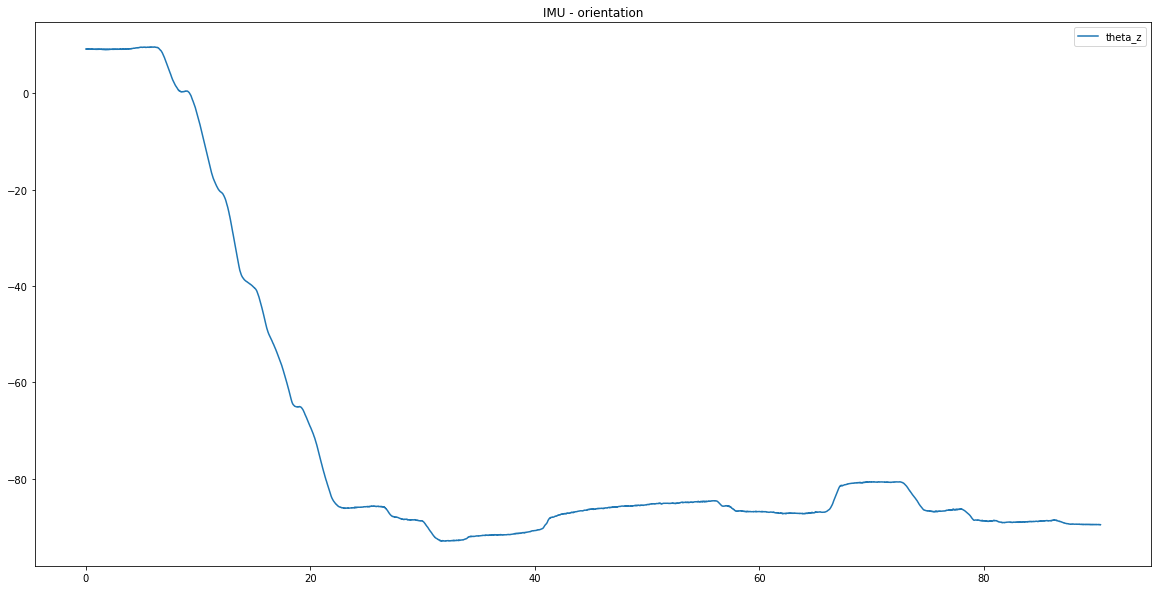

In [51]:
fig, axs = plt.subplots()

axs.plot(tt_imu, np.rad2deg(theta_imu_list), label="theta_z")

plt.title("IMU - orientation")
plt.legend()
plt.show()

# Save the velocities in a txt file

In [52]:
SAVE_OUTPUT = False

In [53]:
if SAVE_OUTPUT:
    os.chdir(Path(project_root() / 'data/radar_odom'))

    np.savetxt('t.out', tt_radar, delimiter=',')
    np.savetxt('v.out', v_list, delimiter=',')
    np.savetxt('v_x.out', v_x_list, delimiter=',')
    np.savetxt('v_y.out', v_y_list, delimiter=',')
    np.savetxt('w.out', omega_list, delimiter=',')

# Plot results

## Least-Squares performance

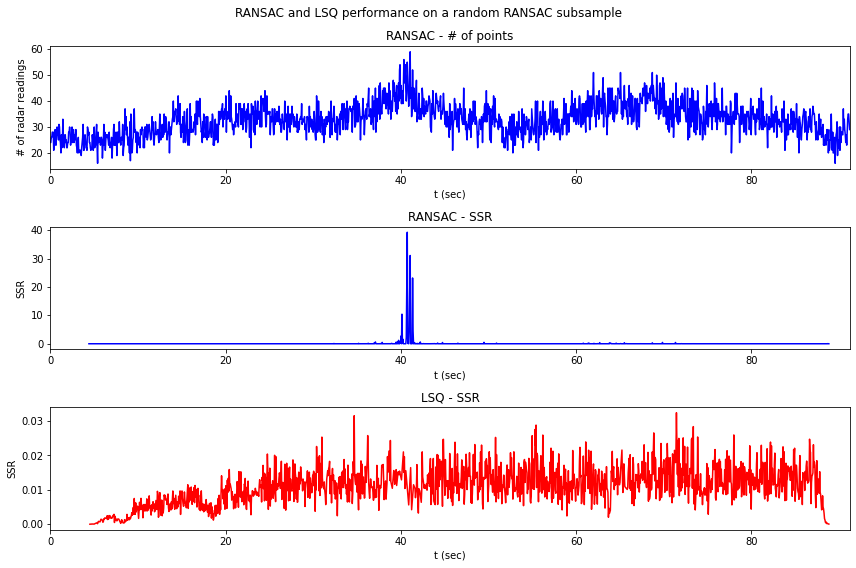

In [54]:
ssr_ransac_list = np.array(ssr_ransac_list, dtype=object)
ssr_lsq_list = np.array(ssr_lsq_list, dtype=object)

fig, axs = plt.subplots(3, figsize=(12,8))

axs[0].plot(tt_radar, num_radar_pts_list, 'b-')
axs[1].plot(tt_radar, ssr_ransac_list, 'b-')
axs[2].plot(t_lsq, ssr_lsq_list, 'r-')

axs[0].title.set_text('RANSAC - # of points')
axs[1].title.set_text('RANSAC - SSR')
axs[2].title.set_text('LSQ - SSR')

for i in range (3):
    axs[i].set_xlim(tt_radar[0], tt_radar[-1])

axs[0].set_xlabel("t (sec)")
axs[0].set_ylabel("# of radar readings")
axs[1].set_xlabel("t (sec)")
axs[1].set_ylabel("SSR")
axs[2].set_xlabel("t (sec)")
axs[2].set_ylabel("SSR")
fig.suptitle("RANSAC and LSQ performance on a random RANSAC subsample")

plt.tight_layout()
plt.show()

In [55]:
# at 40 seconds, there are 2 people right in front of the vehicle moving
# at 60 seconds, 1 person moves in front of the vehicle (a little farther away)

## Ransac performance

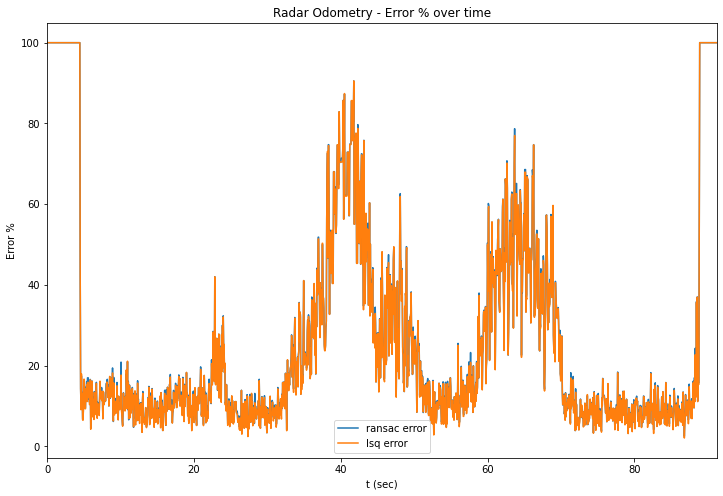

In [56]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(tt_radar, e_pct_ransac, label="ransac error")
ax.plot(tt_radar, e_pct_lsq, label="lsq error")

ax.set_title('Radar Odometry - Error % over time')

ax.set_xlabel("t (sec)")
ax.set_ylabel("Error %")

ax.set_xlim(tt_radar[0], tt_radar[-1])
    
plt.legend()
plt.show()

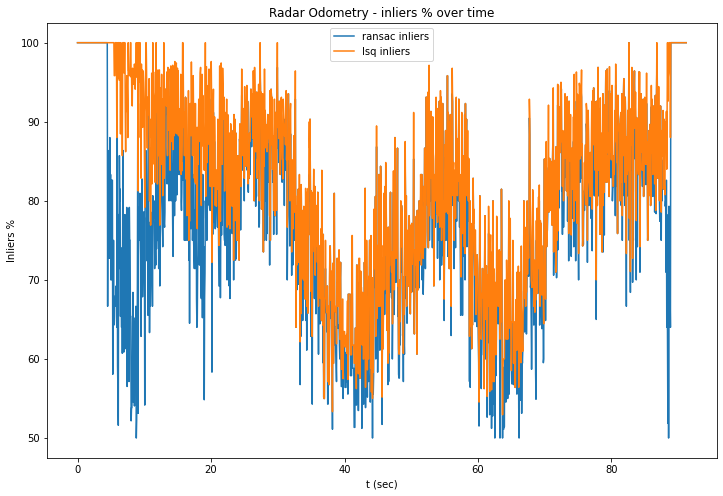

In [57]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(tt_radar, inl_pct_ransac, label="ransac inliers")
ax.plot(tt_radar, inl_pct_lsq, label="lsq inliers")

ax.set_title('Radar Odometry - inliers % over time')

ax.set_xlabel("t (sec)")
ax.set_ylabel("Inliers %")

plt.legend()
plt.show()

## Fit plot

In [58]:
s0 = 200
s1 = 770
s2 = 1108

In [59]:
ts0 = round(t_list[s0], 2)
ts1 = round(t_list[s1], 2)
ts2 = round(t_list[s2], 2)

In [60]:
theta_range = np.arange(-80, 80)
ransac_fit0 = []
for t in theta_range:
    ransac_fit0.append(np.cos(np.deg2rad(t))*v_x_list[s0] + np.sin(np.deg2rad(t))*v_y_list[s0])
ransac_fit1 = []
for t in theta_range:
    ransac_fit1.append(np.cos(np.deg2rad(t))*v_x_list[s1] + np.sin(np.deg2rad(t))*v_y_list[s1])
ransac_fit2 = []
for t in theta_range:
    ransac_fit2.append(np.cos(np.deg2rad(t))*v_x_list[s2] + np.sin(np.deg2rad(t))*v_y_list[s2])

In [61]:
theta_used0 = [np.rad2deg(i) for i in theta_used[s0]]
theta_used1 = [np.rad2deg(i) for i in theta_used[s1]]
theta_used2 = [np.rad2deg(i) for i in theta_used[s2]]

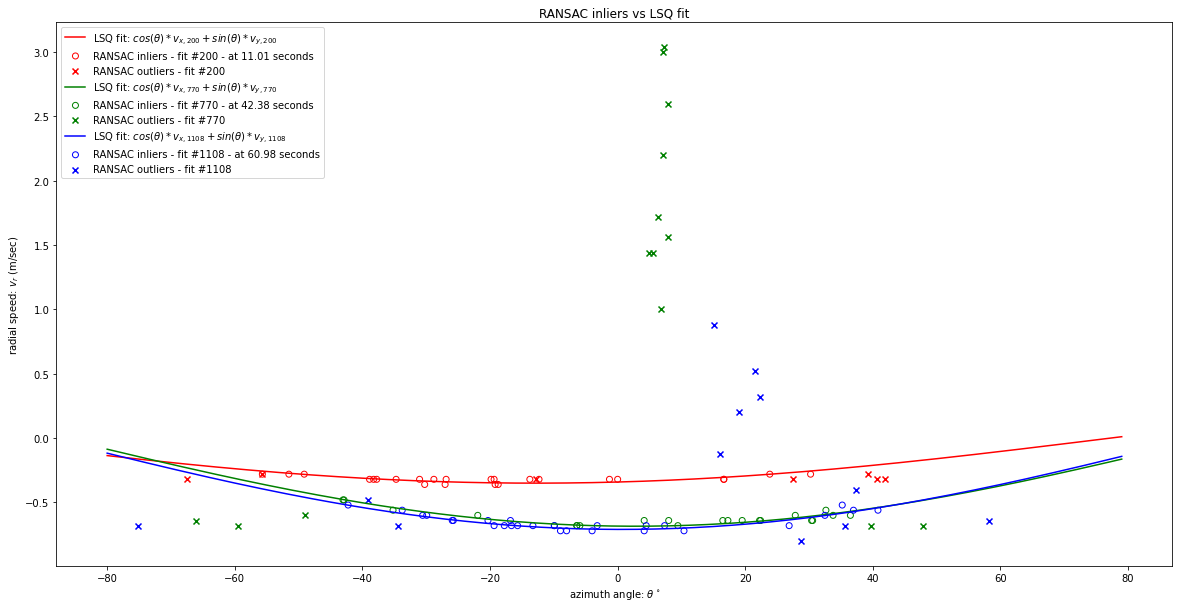

In [62]:
fig, ax = plt.subplots()

ax.plot(theta_range, ransac_fit0, color='r', label="LSQ fit: $cos(θ)*v_{x,200} + sin(θ)*v_{y,200}$")

ax.scatter([theta_used0[i] for i in inlier_list[s0]], 
            [v_r_used[s0][i] for i in inlier_list[s0]], 
            marker='o', facecolors='none', edgecolors='r', label=f"RANSAC inliers - fit #{s0} - at {ts0} seconds")

ax.scatter([theta_used0[i] for i in outlier_list[s0]], 
            [v_r_used[s0][i] for i in outlier_list[s0]], 
            color='r', marker='x', label=f"RANSAC outliers - fit #{s0}")

ax.plot(theta_range, ransac_fit1, color='g', label="LSQ fit: $cos(θ)*v_{x,770} + sin(θ)*v_{y,770}$")

ax.scatter([theta_used1[i] for i in inlier_list[s1]], 
            [v_r_used[s1][i] for i in inlier_list[s1]], 
            marker='o', facecolors='none', edgecolors='g', label=f"RANSAC inliers - fit #{s1} - at {ts1} seconds")

ax.scatter([theta_used1[i] for i in outlier_list[s1]], 
            [v_r_used[s1][i] for i in outlier_list[s1]], 
            color='g', marker='x', label=f"RANSAC outliers - fit #{s1}")

ax.plot(theta_range, ransac_fit2, color='b', label="LSQ fit: $cos(θ)*v_{x,1108} + sin(θ)*v_{y,1108}$")

ax.scatter([theta_used2[i] for i in inlier_list[s2]], 
            [v_r_used[s2][i] for i in inlier_list[s2]], 
            marker='o', facecolors='none', edgecolors='b', label=f"RANSAC inliers - fit #{s2} - at {ts2} seconds")

ax.scatter([theta_used2[i] for i in outlier_list[s2]], 
            [v_r_used[s2][i] for i in outlier_list[s2]], 
            color='b', marker='x', label=f"RANSAC outliers - fit #{s2}")

ax.set_title("RANSAC inliers vs LSQ fit")
ax.set_xlabel("azimuth angle: $ θ^\circ $")
ax.set_ylabel("radial speed: $v_r$ (m/sec)")
plt.legend(loc="upper left")
plt.show()

## All raw velocities (radar vs gps)

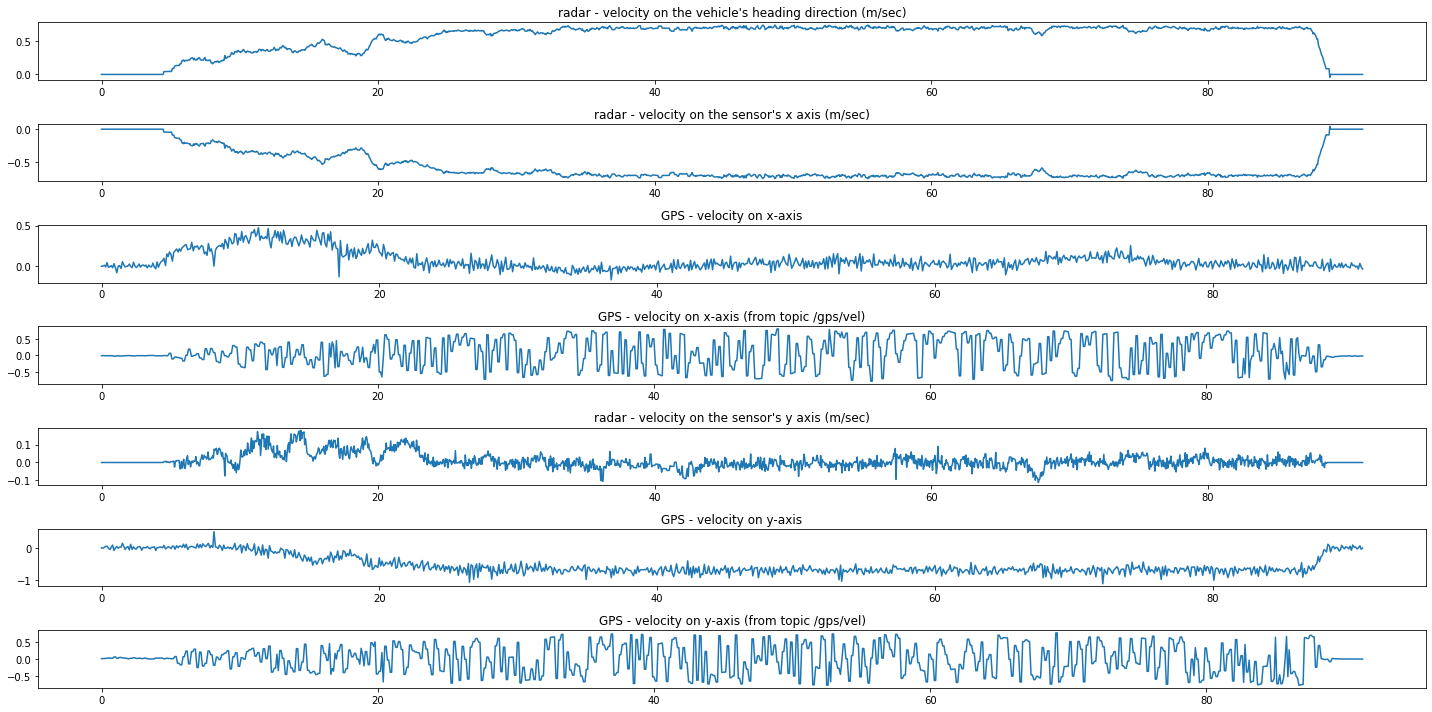

In [63]:
fig, axs = plt.subplots(7)

axs[0].plot(tt_radar, v_list)
axs[1].plot(tt_radar, v_x_list)
axs[2].plot(tt_gps, v_x_gps)
axs[3].plot(tt_gps_topic, v_x_gps_topic)
axs[4].plot(tt_radar, v_y_list)
axs[5].plot(tt_gps, v_y_gps)
axs[6].plot(tt_gps_topic, v_y_gps_topic)

axs[0].title.set_text('radar - velocity on the vehicle\'s heading direction (m/sec)')
axs[1].title.set_text('radar - velocity on the sensor\'s x axis (m/sec)')
axs[2].title.set_text('GPS - velocity on x-axis')
axs[3].title.set_text('GPS - velocity on x-axis (from topic /gps/vel)')    
axs[4].title.set_text('radar - velocity on the sensor\'s y axis (m/sec)')
axs[5].title.set_text('GPS - velocity on y-axis')       
axs[6].title.set_text('GPS - velocity on y-axis (from topic /gps/vel)')       

plt.tight_layout()
plt.show()

## Yaw rate (radar vs imu)

In [64]:
yaw_dif = []
for i in range(len(omega_e_list)):
    # get closest imu reading
    e, idx = get_IMU_reading(tt_radar[i], tt_imu)
    
    yaw_dif.append(ang_vel_e[idx,2] - omega_e_list[i])

print("Mean difference between IMU and Radar yaw rate: ", np.mean(yaw_dif))

Mean difference between IMU and Radar yaw rate:  -0.4448628881037983


In [65]:
# print the total absolute position error, 
print(f"Total error: {sum(yaw_dif)} .")
print(f"Mean: {np.mean(yaw_dif)} .")
print(f"Std. deviation: {np.std(yaw_dif)} .")
print(f"Variance: {np.var(yaw_dif)} .")
print(f"[min, max]: {[min(yaw_dif), max(yaw_dif)]} .")

Total error: -737.582668476096 .
Mean: -0.4448628881037983 .
Std. deviation: 3.1402395098704385 .
Variance: 9.861104179351331 .
[min, max]: [-13.126809232444122, 11.017876366856536] .


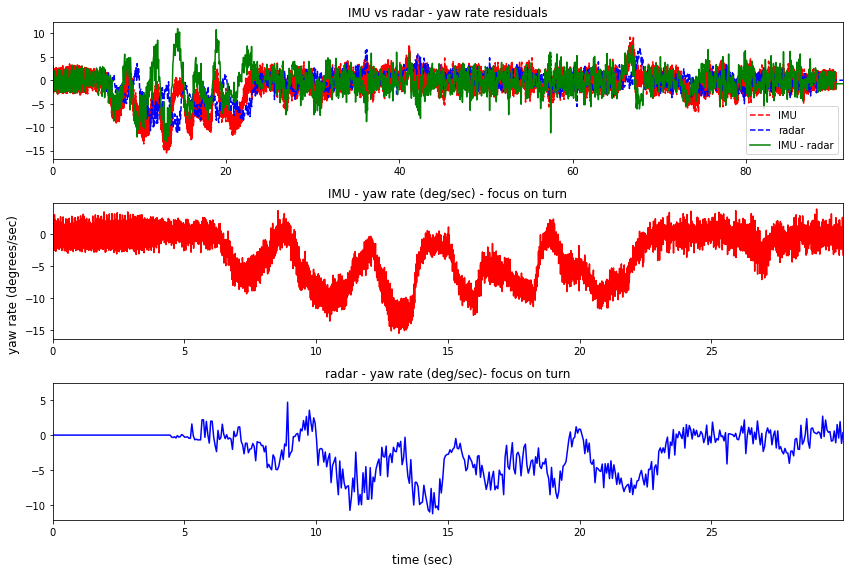

In [66]:
fig, axs = plt.subplots(3, figsize=(12,8))

axs[0].plot(tt_imu, np.array(ang_vel_e)[:,2], 'r--', label="IMU")
axs[0].plot(tt_radar, omega_e_list, 'b--', label="radar")
axs[0].plot(tt_radar, yaw_dif, 'g-', label="IMU - radar")

axs[1].plot(tt_imu[0:3000], np.array(ang_vel_e)[0:3000,2], 'r-')
axs[2].plot(tt_radar[0:850], omega_e_list[0:850], 'b-')

axs[0].set_title("IMU vs radar - yaw rate residuals")
axs[1].title.set_text('IMU - yaw rate (deg/sec) - focus on turn')
axs[2].title.set_text('radar - yaw rate (deg/sec)- focus on turn')

axs[0].set_xlim(tt_radar[0], tt_radar[-1])

axs[1].set_xlim(0,tt_radar[545])
axs[2].set_xlim(0,tt_imu[3000])

fig.supxlabel("time (sec)")
fig.supylabel("yaw rate (degrees/sec)")
plt.tight_layout()
axs[0].legend()
plt.show()

## Knematics equations

![Movement with coupled linear and angular velocity.](images/coupled_linear_angular_vel_pol.png)

![Movement with coupled linear and angular velocity.](images/coupled_linear_angular_vel_cart.png)

## GPS vs GPS vel (from topic) vs GPS + IMU

### Kinematics

In [67]:
# using velocity from topic /gps/vel - TRASH

x_gps_imu_topic = []
y_gps_imu_topic = []
for i in range(len(tt_gps_topic)):
    
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        x, y, vx, vy, theta = 0, 0, 0, 0, orientation_init
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps_topic[i] - tt_gps_topic[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
            
        # now get the closest IMU reading
#         print(tt_radar[i], tt_imu[0])
        e, idx = get_IMU_reading(tt_gps_topic[i], tt_imu)
        w_imu = ang_vel[idx][2]

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        theta = theta_imu_list[idx]
        v1 = v_x_gps_topic[i]
        v2 = v_y_gps_topic[i]
        if w_imu != 0:
            x = x_prev + ( (v1/w_imu) * np.sin(w_imu*dt) ) - ( (v2/w_imu) * (1 - np.cos(w_imu*dt)) )
            y = y_prev + ( (v1/w_imu) * (1 - np.cos(w_imu*dt)) ) + ( (v2/w_imu) * np.sin(w_imu*dt) )
        else:
            x = x_prev + v1*dt
            y = y_prev + v2*dt
        
    x_gps_imu_topic.append(x)
    y_gps_imu_topic.append(y)
        
    x_prev = x
    y_prev = y
    theta_prev = theta

In [68]:
# using velocity from the gps x,y coordinates

x_gps_imu = []
y_gps_imu = []
v_x_gps_imu = []
v_y_gps_imu = []

for i in range(len(tt_gps)):
    
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        x, y, vx, vy, theta = 0, 0, 0, 0, orientation_init
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps[i] - tt_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
            
        # now get the closest IMU reading
#         print(tt_radar[i], tt_imu[0])
        e, idx = get_IMU_reading(tt_gps[i], tt_imu)
        w_imu = ang_vel[idx][2]

        # now depending on dt and the linear and angular velocities, we can update the positions with kinematics
        theta = theta_imu_list[i]
        v1 = v_x_gps[i]
        v2 = v_y_gps[i]
        vx = v1*np.cos(w_imu*dt) - v2*np.sin(w_imu*dt)
        vy = v1*np.sin(w_imu*dt) + v2*np.cos(w_imu*dt)
        if w_imu != 0:
            x = x_prev + ( (v1/w_imu) * np.sin(w_imu*dt) ) - ( (v2/w_imu) * (1 - np.cos(w_imu*dt)) )
            y = y_prev + ( (v1/w_imu) * (1 - np.cos(w_imu*dt)) ) + ( (v2/w_imu) * np.sin(w_imu*dt) )
        else:
            x = x_prev + v1*dt
            y = y_prev + v2*dt
        
    x_gps_imu.append(x)
    y_gps_imu.append(y)
    v_x_gps_imu.append(vx)
    v_y_gps_imu.append(vy)

    x_prev = x
    y_prev = y
    theta_prev = theta

### Convert from cartesian to polar velocity

In [69]:
# convert cartesian gps velocity to polar to compare with radar odometry later
v_gps_imu = []
alpha_gps_imu = []
for i in range(len(x_gps_imu)):   
    v = (v_x_gps_imu[i]**2 + v_y_gps_imu[i]**2)**0.5 # convert cartesian velocity to polar
    alp = np.arctan2(v_y_gps_imu[i], v_x_gps_imu[i])

    alpha_gps_imu.append(alp)
    v_gps_imu.append(v)

### Add white noise

In [70]:
# add some noise to the radial velocity signal
mean = 0
std = 0.075 # half of the difference
v_noise = np.random.normal(mean, std, size=len(v_gps_imu))
v_gps_imu_noise = v_gps_imu + v_noise

In [71]:
x_gps_imu_noise = []
y_gps_imu_noise = []

for i in range(len(tt_gps)):
    
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        x, y, theta = 0, 0, orientation_init
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps[i] - tt_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
            
        # now get the closest IMU reading
        e, idx = get_IMU_reading(tt_gps[i], tt_imu)
        w_imu = ang_vel[idx][2]
            
        # now depending on the distance travelled in the heading direction, we can get dx, dy
        theta = theta_imu_list[idx]
        if w_imu != 0:
            x = x_prev + ( (2*v_gps_imu_noise[i]/w_imu) * 
                          np.sin(w_imu*dt/2) * 
                          np.cos(theta_prev + w_imu*dt/2) )
            y = y_prev + ( (2*v_gps_imu_noise[i]/w_imu) *
                          np.sin(w_imu*dt/2) *
                          np.sin(theta_prev + w_imu*dt/2) )
        else:
            # distance in the heading direction
            l = v_gps_imu_noise[i]*dt

            # now depending on the distance travelled in the heading direction, we can get dx, dy
            x = x_prev + np.cos(theta)*l
            y = y_prev + np.sin(theta)*l
        
    x_gps_imu_noise.append(x)
    y_gps_imu_noise.append(y)
        
    x_prev = x
    y_prev = y
    theta_prev = theta

### Interpolate to remove spikes

In [72]:
# interpolate the radial velocity signal to remove spikes
v_gps_imu_means = []
tt_gps_means = []
m = 10
i=0
while i < len(v_gps_imu):
  if i+m < len(v_gps_imu):
    v_ = np.mean(v_gps_imu[i:i+m])
    v_gps_imu_means.append(v_)

    t_ = np.mean(tt_gps[i:i+m])
    tt_gps_means.append(t_)
  else:
    v_ = np.mean(v_gps_imu[i:])
    v_gps_imu_means.append(v_)

    t_ = np.mean(tt_gps[i:])
    tt_gps_means.append(t_)

  i+=10

In [73]:
x_gps_imu_means = []
y_gps_imu_means = []

for i in range(len(tt_gps_means)):
    
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        x, y, theta = 0, 0, orientation_init
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps_means[i] - tt_gps_means[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
            
        # now get the closest IMU reading
        e, idx = get_IMU_reading(tt_gps_means[i], tt_imu)
        w_imu = ang_vel[idx][2]
            
        # now depending on the distance travelled in the heading direction, we can get dx, dy
        theta = theta_imu_list[idx]
        if w_imu != 0:
            x = x_prev + ( (2*v_gps_imu_means[i]/w_imu) * 
                          np.sin(w_imu*dt/2) * 
                          np.cos(theta_prev + w_imu*dt/2) )
            y = y_prev + ( (2*v_gps_imu_means[i]/w_imu) *
                          np.sin(w_imu*dt/2) *
                          np.sin(theta_prev + w_imu*dt/2) )
        else:
            # distance in the heading direction
            l = v_gps_imu_means[i]*dt

            # now depending on the distance travelled in the heading direction, we can get dx, dy
            x = x_prev + np.cos(theta)*l
            y = y_prev + np.sin(theta)*l
        
    x_gps_imu_means.append(x)
    y_gps_imu_means.append(y)
        
    x_prev = x
    y_prev = y
    theta_prev = theta

### Plot

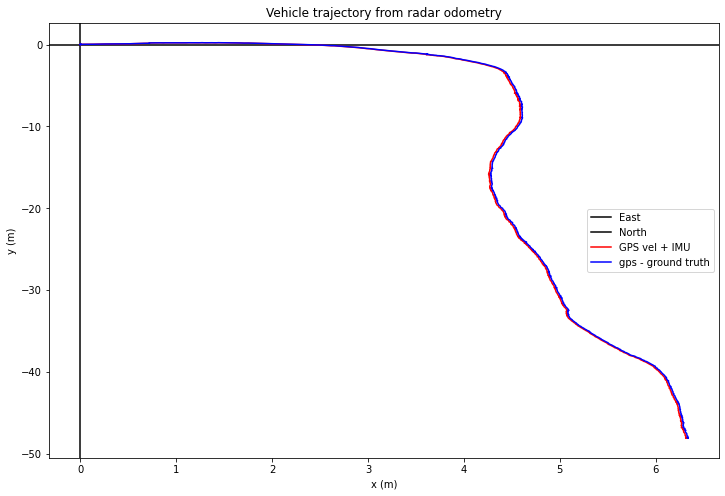

In [74]:
fig, ax = plt.subplots(figsize=(12,8))

ax.axhline(y=0, color='k', linestyle='-', label="East")
ax.axvline(x=0, color='k', linestyle='-', label="North")

ax.plot(x_gps_imu, y_gps_imu, 'r-', label = "GPS vel + IMU")
# ax.plot(x_gps_imu_topic, y_gps_imu_topic, 'g-', label = "GPS vel (topic) + IMU")
ax.plot(x_gps, y_gps, 'b-', label = "gps - ground truth")
ax.set_title("Vehicle trajectory from radar odometry")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
#plt.axis('equal')
plt.legend()
plt.show()

## GPS + IMU vs Radar Odom : polar velocity

In [75]:
print(len(tt_radar), len(tt_gps))

1658 909


In [76]:
temp_dif = []
for i in range(len(v_list)):
    # get closest imu reading
    e, idx = get_IMU_reading(tt_radar[i], tt_gps)
    
    temp_dif.append(v_gps_imu[idx] - v_list[i])

print("Mean/std. deviation of residuals: ", np.mean(temp_dif), np.std(temp_dif))

Mean/std. deviation of residuals:  0.008440058269720194 0.10176829123717653


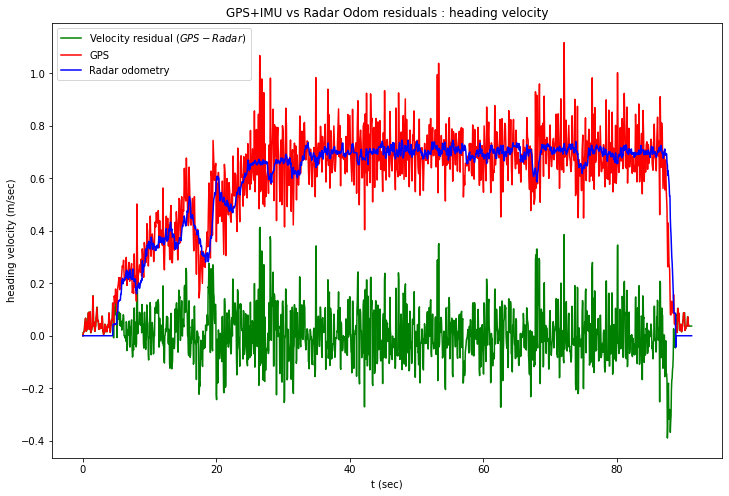

In [77]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(tt_radar, temp_dif, 'g-', label = "Velocity residual ($GPS - Radar$)")
ax.plot(tt_gps, v_gps_imu, 'r-', label = "GPS")
ax.plot(tt_radar, v_list, 'b-', label = "Radar odometry")

ax.set_title("GPS+IMU vs Radar Odom residuals : heading velocity")
ax.set_xlabel("t (sec)")
ax.set_ylabel("heading velocity (m/sec)")
plt.legend()
plt.show()

## Radar

### Radar Odom

In [78]:
# define possible bias for radar odometry (based on previous experiments)
bias = 0.1 # doesn't work

In [79]:
# extract orientation from radar odometry
theta_odom_list = []
for i in range(len(tt_radar)):
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        theta = orientation_init
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_radar[i] - tt_radar[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
            
        # get yaw rate from the radar odometry returns
        w_odom = omega_list[i]
            
        # assuming 0 angular acceleration
        theta = theta_prev + w_odom*dt
        
    theta_odom_list.append(theta)
        
    theta_prev = theta

In [80]:
dist = 0
x_radar = []
y_radar = []
x_radar_bias = []
y_radar_bias = []
for i in range(len(v_list)):
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        x, y, theta = 0, 0, orientation_init
        x_bias, y_bias = 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = t_radar[i] - t_radar[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
            
        # now depending on the distance travelled in the heading direction, we can get dx, dy
        theta = theta_odom_list[i]
        if omega_list[i] != 0:
            v_bias = v_list[i]-bias # bias based on previous experiments
            x = x_prev + ((2*v_list[i]/omega_list[i]) * \
                    np.sin(omega_list[i]*dt/2) * \
                        np.cos(theta_prev + omega_list[i]*dt/2))
            x_bias = x_prev_bias + ((2*v_bias/omega_list[i]) * \
                    np.sin(omega_list[i]*dt/2) * \
                        np.cos(theta_prev + omega_list[i]*dt/2))
            y = y_prev + ((2*v_list[i]/omega_list[i]) *\
                    np.sin(omega_list[i]*dt/2) *\
                        np.sin(theta_prev + omega_list[i]*dt/2))
            y_bias = y_prev_bias + ((2*v_bias/omega_list[i]) *\
                    np.sin(omega_list[i]*dt/2) *\
                        np.sin(theta_prev + omega_list[i]*dt/2))
        else:
            v_bias = v_list[i]-bias # bias based on previous experiments
            # distance in the heading direction
            l = v_list[i]*dt
            l_bias = v_bias*dt

            # now depending on the distance travelled in the heading direction, we can get dx, dy
            x = x_prev + np.cos(theta)*l
            y = y_prev + np.sin(theta)*l
            x_bias = x_prev_bias + np.cos(theta)*l_bias
            y_bias = y_prev_bias + np.sin(theta)*l_bias
            
    x_radar.append(x)
    y_radar.append(y)
    x_radar_bias.append(x_bias)
    y_radar_bias.append(y_bias)
        
    x_prev = x
    y_prev = y
    x_prev_bias = x_bias
    y_prev_bias = y_bias
    theta_prev = theta

### Radar odom + IMU

In [81]:
x_radar_imu = []
y_radar_imu = []
x_radar_imu_bias = []
y_radar_imu_bias = []

# debug
d4 = []
d5 = []
d6 = []

for i in range(len(tt_radar)):
    
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        x, y, theta = 0, 0, orientation_init
        x_bias, y_bias = 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_radar[i] - tt_radar[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
            
        # now get the closest IMU reading
#         print(tt_radar[i], tt_imu[0])
        e, idx = get_IMU_reading(tt_radar[i], tt_imu)
        w_imu = ang_vel[idx][2]
            
        # now depending on the distance travelled in the heading direction, we can get dx, dy
        theta = theta_imu_list[idx]
        if w_imu != 0:
            v_bias = v_list[i]-bias # bias based on previous experiments
            x = x_prev + ( (2*v_list[i]/w_imu) * 
                          np.sin(w_imu*dt/2) * 
                          np.cos(theta_prev + w_imu*dt/2) )
            x_bias = x_prev_bias + ((2*v_bias/w_imu) * \
                    np.sin(w_imu*dt/2) * \
                        np.cos(theta_prev + w_imu*dt/2))
            y = y_prev + ( (2*v_list[i]/w_imu) *
                          np.sin(w_imu*dt/2) *
                          np.sin(theta_prev + w_imu*dt/2) )
            y_bias = y_prev_bias + ((2*v_bias/w_imu) *\
                    np.sin(w_imu*dt/2) *\
                        np.sin(theta_prev + w_imu*dt/2))
        else:
            v_bias = v_list[i]-bias # bias based on previous experiments
            # distance in the heading direction
            l = v_list[i]*dt

            # now depending on the distance travelled in the heading direction, we can get dx, dy
            x = x_prev + np.cos(theta)*l
            y = y_prev + np.sin(theta)*l
            x_bias = x_prev_bias + np.cos(theta)*l_bias
            y_bias = y_prev_bias + np.sin(theta)*l_bias
        
    x_radar_imu.append(x)
    y_radar_imu.append(y)
    x_radar_imu_bias.append(x_bias)
    y_radar_imu_bias.append(y_bias)

    # debug
    d4.append(tt_radar[i])
    d5.append(w_imu)
    d6.append(v_list[i])
        
    x_prev = x
    y_prev = y
    theta_prev = theta

### Combined plot and total distance travelled

In [82]:
d_gps = 0
for i in range(1, len(x_gps)):
    d_gps += np.sqrt((x_gps[i]-x_gps[i-1])**2 + (y_gps[i]-y_gps[i-1])**2)

dt = t_gps[-1] - t_gps[0]
print(f"Distance covered by vehicle according to the GPS over {dt} seconds: {d_gps} m")

d_gps_imu = 0
for i in range(1, len(x_gps)):
    d_gps_imu += np.sqrt((x_gps_imu[i]-x_gps_imu[i-1])**2 + (y_gps_imu[i]-y_gps_imu[i-1])**2)

dt = t_gps[-1] - t_gps[0]
print(f"Distance covered by vehicle according to the GPS and IMU over {dt} seconds: {d_gps_imu} m")

d_gps_imu_means = 0
for i in range(1, len(x_gps_imu_means)):
    d_gps_imu_means += np.sqrt((x_gps_imu_means[i]-x_gps_imu_means[i-1])**2 + (y_gps_imu_means[i]-y_gps_imu_means[i-1])**2)

dt = tt_gps_means[-1] - tt_gps_means[0]
print(f"Distance covered by vehicle according to the GPS and IMU (interpolated) over {dt} seconds: {d_gps_imu} m")

d_gps_imu_noise = 0
for i in range(1, len(x_gps)):
    d_gps_imu_noise += np.sqrt((x_gps_imu_noise[i]-x_gps_imu_noise[i-1])**2 + (y_gps_imu_noise[i]-y_gps_imu_noise[i-1])**2)

dt = t_gps[-1] - t_gps[0]
print(f"Distance covered by vehicle according to the GPS (w. noise) and IMU over {dt} seconds: {d_gps_imu_noise} m")

d_radar_odom = 0
for i in range(1, len(x_radar)):
    d_radar_odom += np.sqrt((x_radar[i]-x_radar[i-1])**2 + (y_radar[i]-y_radar[i-1])**2)
dt = t_radar[-1] - t_radar[0]
print(f"Distance covered by vehicle according to the the Radar Odometry over {dt} seconds: {d_radar_odom} m")

d_radar_odom_bias = 0
for i in range(1, len(x_radar)):
    d_radar_odom_bias += np.sqrt((x_radar_bias[i]-x_radar_bias[i-1])**2 + (y_radar_bias[i]-y_radar_bias[i-1])**2)
dt = t_radar[-1] - t_radar[0]
print(f"Distance covered by vehicle according to the the Radar Odometry (w. bias) over {dt} seconds: {d_radar_odom_bias} m")

d_radar_imu = 0
for i in range(1, len(x_radar)):
    d_radar_imu += np.sqrt((x_radar_imu[i]-x_radar_imu[i-1])**2 + (y_radar_imu[i]-y_radar_imu[i-1])**2)
print(f"Distance covered by vehicle according to the Radar and IMU over {dt} seconds: {d_radar_imu} m")

d_radar_imu_bias = 0
for i in range(1, len(x_radar)):
    d_radar_imu_bias += np.sqrt((x_radar_imu_bias[i]-x_radar_imu_bias[i-1])**2 + (y_radar_imu_bias[i]-y_radar_imu_bias[i-1])**2)
print(f"Distance covered by vehicle according to the Radar (w. bias) and IMU over {dt} seconds: {d_radar_imu_bias} m")


Distance covered by vehicle according to the GPS over 90.80186104774475 seconds: 51.88292258252358 m
Distance covered by vehicle according to the GPS and IMU over 90.80186104774475 seconds: 51.88286202665045 m
Distance covered by vehicle according to the GPS and IMU (interpolated) over 89.95239894390106 seconds: 51.88286202665045 m
Distance covered by vehicle according to the GPS (w. noise) and IMU over 90.80186104774475 seconds: [51.94576004] m
Distance covered by vehicle according to the the Radar Odometry over 91.19769406318665 seconds: 51.41251650597173 m
Distance covered by vehicle according to the the Radar Odometry (w. bias) over 91.19769406318665 seconds: 43.74784230406501 m
Distance covered by vehicle according to the Radar and IMU over 91.19769406318665 seconds: [51.41250984] m
Distance covered by vehicle according to the Radar (w. bias) and IMU over 91.19769406318665 seconds: [42.52695485] m


/home/glob/anaconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


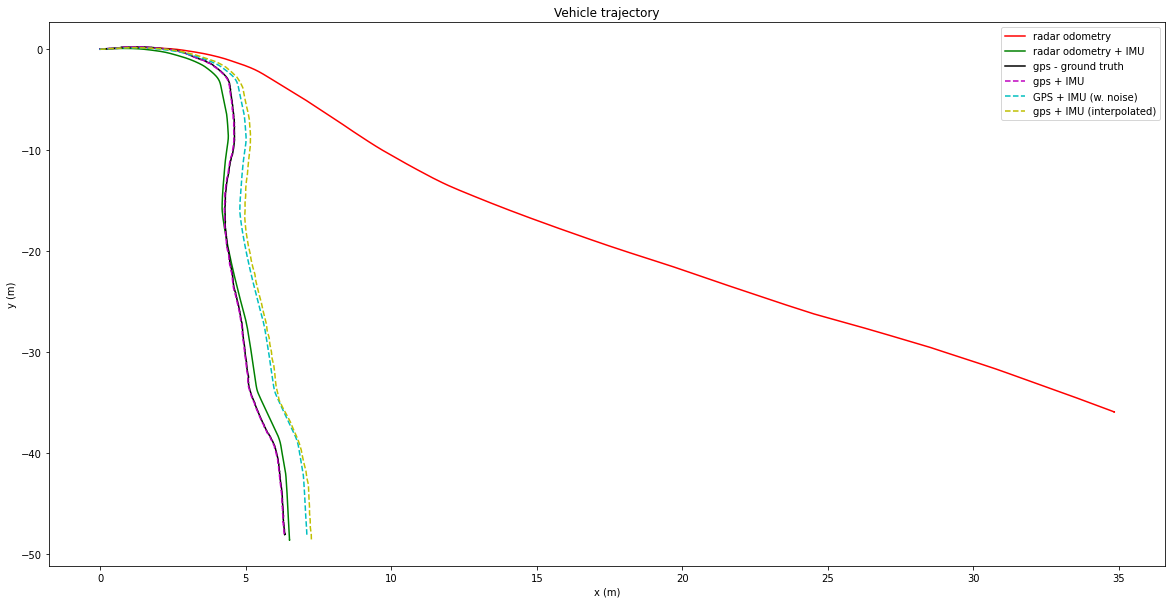

In [83]:
save_plot = False

plt.plot(x_radar, y_radar, 'r-', label = "radar odometry")
# plt.plot(x_radar_bias, y_radar_bias, 'm-.', label = "radar odometry (w. bias)")
plt.plot(x_radar_imu, y_radar_imu, 'g-', label = "radar odometry + IMU")
# plt.plot(x_radar_imu_bias, y_radar_imu_bias, 'y-.', label = "radar odometry (w. bias) + IMU")
plt.plot(x_gps, y_gps, 'k-', label = "gps - ground truth")
plt.plot(x_gps_imu, y_gps_imu, 'm--', label = "gps + IMU")
plt.plot(x_gps_imu_noise, y_gps_imu_noise, 'c--', label = "GPS + IMU (w. noise)")
plt.plot(x_gps_imu_means, y_gps_imu_means, 'y--', label = "gps + IMU (interpolated)")
plt.title("Vehicle trajectory")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
# plt.axis('equal')
plt.legend()
if save_plot:
    os.chdir(Path(project_root() / 'plots'))
    plt.savefig(f'trajectories_{num_scans}_scans.png')
plt.show()

## GPS + IMU vs Radar + IMU: cartesian velocity

### Convert Radar Odom polar velocity to cartesian using the IMU orientation

In [84]:
v_x_radar_imu = []
v_y_radar_imu = []

th = orientation_init
for i in range(len(v_list)):
    if i>0:     
        # get dt in seconds
        dt = tt_radar[i] - tt_radar[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}. Iteration: {i}")

        # now get the closest IMU reading and use it to find the total angle covered
        e, idx = get_IMU_reading(tt_radar[i], tt_imu)
        w_imu = ang_vel[idx][2]
        _ = w_imu*dt
        th+=(_)

        # using the imu orientation convert to real vx and vy (considering coupled linear and angular movement)
        vx = v_list[i]*np.cos(th)
        vy = v_list[i]*np.sin(th)
    else:
        vx = 0
        vy = 0
#         th += orientation_init
    
    v_x_radar_imu.append(vx)
    v_y_radar_imu.append(vy)

### Plot

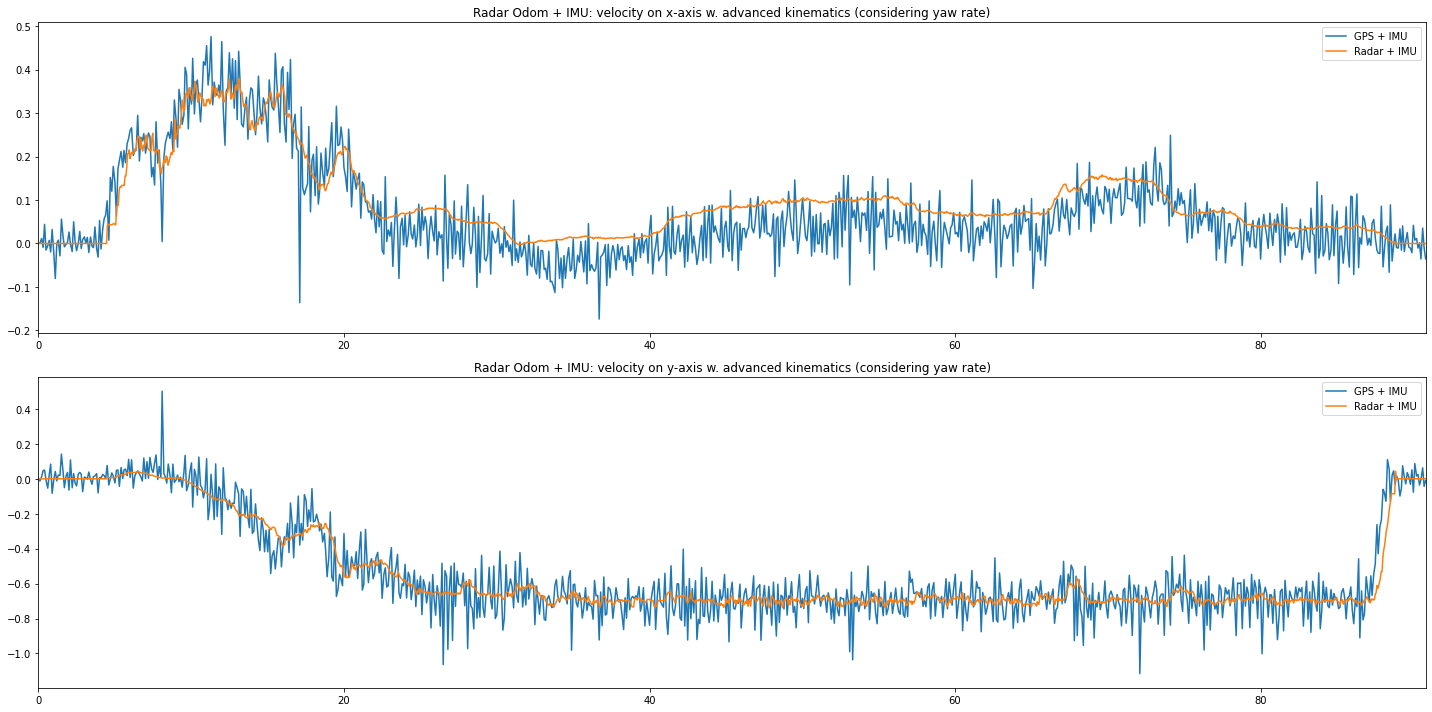

In [85]:
# be careful, here the velocities are with respect to the east/north gps0 frame, so it is only natural to have different velocities, as soon as some drift is accumulated.
# if they we w.r.t the base_link frame, they would be very similar.

fig, axs = plt.subplots(2)

axs[0].plot(tt_gps, v_x_gps_imu, label="GPS + IMU")
axs[0].plot(tt_radar, v_x_radar_imu, label="Radar + IMU")
axs[1].plot(tt_gps, v_y_gps_imu, label="GPS + IMU")
axs[1].plot(tt_radar, v_y_radar_imu, label="Radar + IMU")

axs[0].title.set_text('Radar Odom + IMU: velocity on x-axis w. advanced kinematics (considering yaw rate)')
axs[1].title.set_text('Radar Odom + IMU: velocity on y-axis w. advanced kinematics (considering yaw rate)')    

plt.tight_layout()
axs[0].legend()
axs[1].legend()

for i in range(2):
    axs[i].set_xlim(min(tt_gps), max(tt_gps))
plt.show()

# here, the error is likely caused by an orientation error, which likely comes from the IMU
# this can be observed by the ESEKF gps-imu fusion, which reveals a deviation from the IMU-predicted orientation!

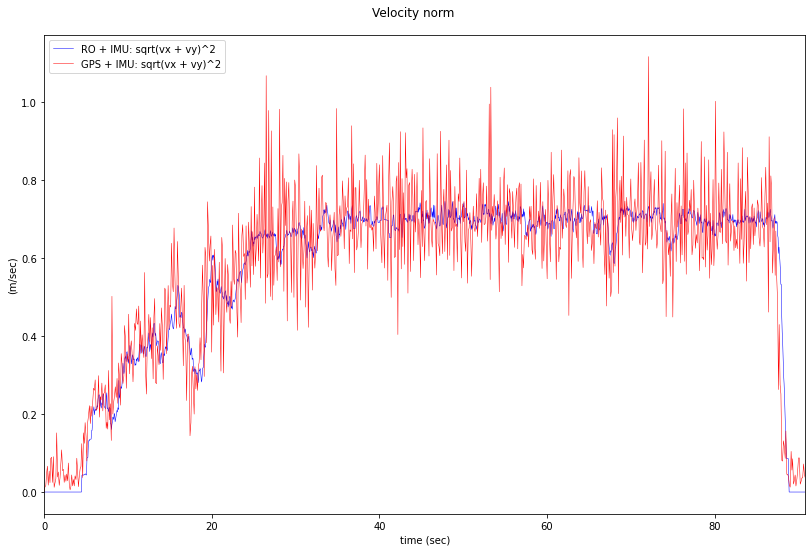

In [86]:
# plot the velocity norm
fig, axs = plt.subplots(figsize=(12,8))

axs.plot(tt_radar, np.sqrt(np.array(v_x_radar_imu)**2 + np.array(v_y_radar_imu)**2), 
         'b-', linewidth=0.5, label="RO + IMU: sqrt(vx + vy)^2")
axs.plot(tt_gps, np.sqrt(np.array(v_x_gps_imu)**2 + np.array(v_y_gps_imu)**2), 
         'r-', linewidth=0.5, label="GPS + IMU: sqrt(vx + vy)^2")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs.legend()

plt.xlabel("time (sec)")
plt.ylabel("(m/sec)")
plt.suptitle("Velocity norm")

plt.xlim(min(tt_gps), max(tt_gps))
plt.show()
plt.show()

## Trajectories with pseudo-fusion

<IPython.core.display.Javascript object>


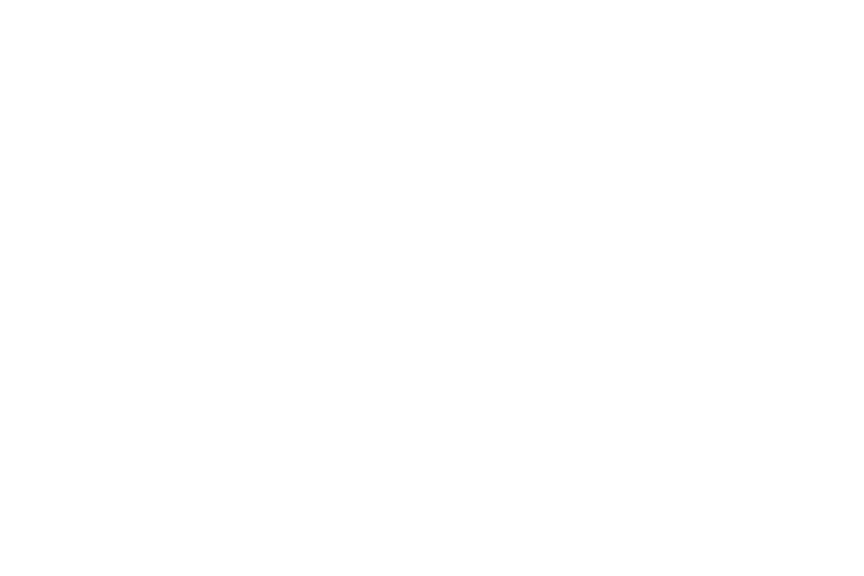

In [87]:
%matplotlib notebook
matplotlib.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12,8))

# plt.plot(x_radar, y_radar, 'r-', label = "radar odometry")
# plt.plot(x_radar_imu, y_radar_imu, 'g-', label = "radar odometry + IMU")
ax.plot(x_gps, y_gps, 'b-', label = "GPS - ground truth")
ax.scatter(x_gps[0], y_gps[0], color="green", label="start")
ax.scatter(x_gps[-1], y_gps[-1], color="red", label="end")
ax.set_title("2d trajectory")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
plt.legend()
plt.show()

## Orientation (radar vs IMU)

### Initial orientation

<IPython.core.display.Javascript object>


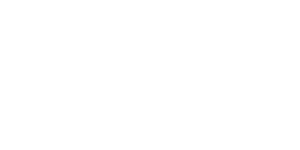

/home/glob/anaconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [88]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(x_radar[0:300], y_radar[0:300], 'r-', label = "radar odometry")
ax.plot(x_radar_imu[0:300], y_radar_imu[0:300], 'g-', label = "radar odometry + IMU")
ax.plot(x_gps[0:170], y_gps[0:170], 'b-', label = "gps - ground truth")
ax.set_title("Initial trajectory / orientation")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
plt.legend()
plt.show()

### Orientation

In [89]:
theta_imu_short = np.empty((0,1), float)
for i in range(len(tt_radar)):
    dt, idx = get_IMU_reading(tt_radar[i], tt_imu)
    theta_imu_short = np.append(theta_imu_short, theta_imu_list[idx])

In [90]:
traj_RMSE(np.rad2deg(theta_odom_list), np.rad2deg(theta_imu_short))

34.4637864180227

<IPython.core.display.Javascript object>


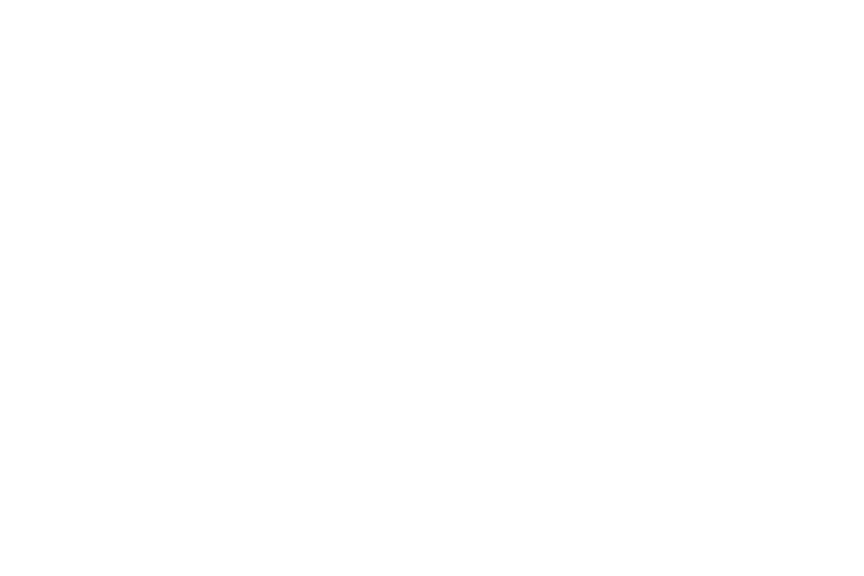

In [91]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(tt_imu, np.rad2deg(theta_imu_list), 'r-', label = "imu orientation")
ax.plot(tt_radar, np.rad2deg(theta_odom_list), 'b-', label = "radar odometry orientation")

ax.set_title("Orientation of the vehicle")
ax.set_xlabel("t (sec)")
ax.set_ylabel("yaw (degrees)")
plt.legend()
plt.show()

# Statistical Analysis of residuals

## Correlation analysis

<IPython.core.display.Javascript object>


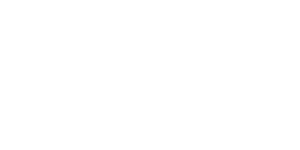

# of samples: 1658


In [92]:
fig, ax = plt.subplots(figsize=(10,4))

print(f"# of samples: {len(temp_dif)}")
ax.scatter(tt_radar, temp_dif, s=2)

ax.set_title("Velocity Residuals")
ax.set_xlabel("time")
ax.set_ylabel("dv (m/sec)")
plt.show()

<IPython.core.display.Javascript object>


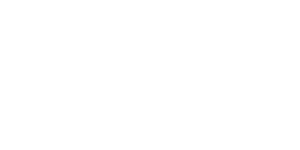

In [93]:
fig, ax = plt.subplots(figsize=(4,4))

plt.acorr(temp_dif, maxlags = 10)

ax.set_title("Autocorrelation Plot") 
ax.set_ylabel("correlation")
ax.set_xlabel("Lags")

plt.grid(True) 
plt.show()

## Best fit functions

In [94]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))
        
        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
#                 print(sse)
                
                # if axis pass in add to plot
                try:
                    if ax and sse<20:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## Heading Velocity residuals (GPS vs Radar)

Total error: 13.993616611196055 .
Mean: 0.008440058269720194 .
Std. deviation: 0.10176829123717653 .
Variance: 0.010356785101334781 .
[min, max]: [-0.3896793506243743, 0.41293459225406814] .


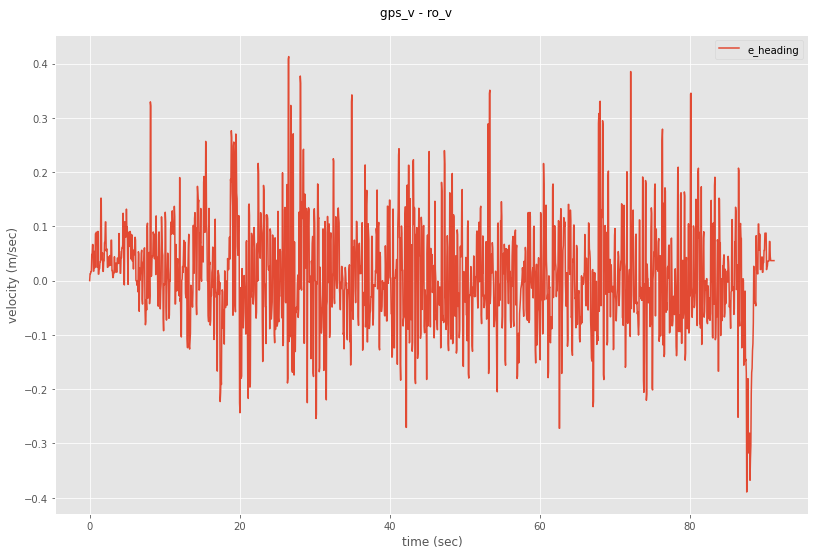

In [95]:
# print the total absolute position error, 
print(f"Total error: {sum(temp_dif)} .")
print(f"Mean: {np.mean(temp_dif)} .")
print(f"Std. deviation: {np.std(temp_dif)} .")
print(f"Variance: {np.var(temp_dif)} .")
print(f"[min, max]: {[min(temp_dif), max(temp_dif)]} .")

# plot the position error over time
fig, axs = plt.subplots(figsize=(12,8))
axs.plot(tt_radar, temp_dif, label="e_heading")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs.legend()

plt.xlabel("time (sec)")
plt.ylabel("velocity (m/sec)")
plt.suptitle("gps_v - ro_v")
plt.show()

## Correlation analysis
The generalized likelihood ratio test assumes that the samples are independent and identically distributed.
Even if we say that the first statement is correct based on our statistical analysis, the samples are probably not independent. We will, therefore, perform a correlation analysis on the residuals to check to what extend that holds true.

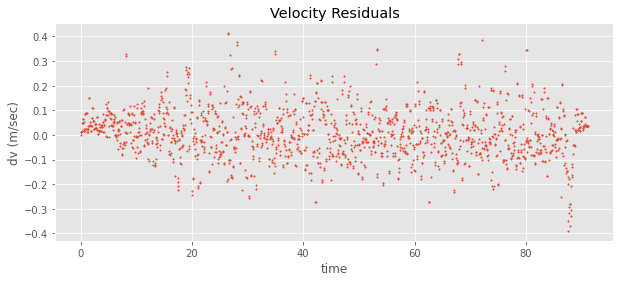

In [96]:
fig, ax = plt.subplots(figsize=(10,4))

ax.scatter(tt_radar, temp_dif, s=2)

ax.set_title("Velocity Residuals")
ax.set_xlabel("time")
ax.set_ylabel("dv (m/sec)")
plt.show()

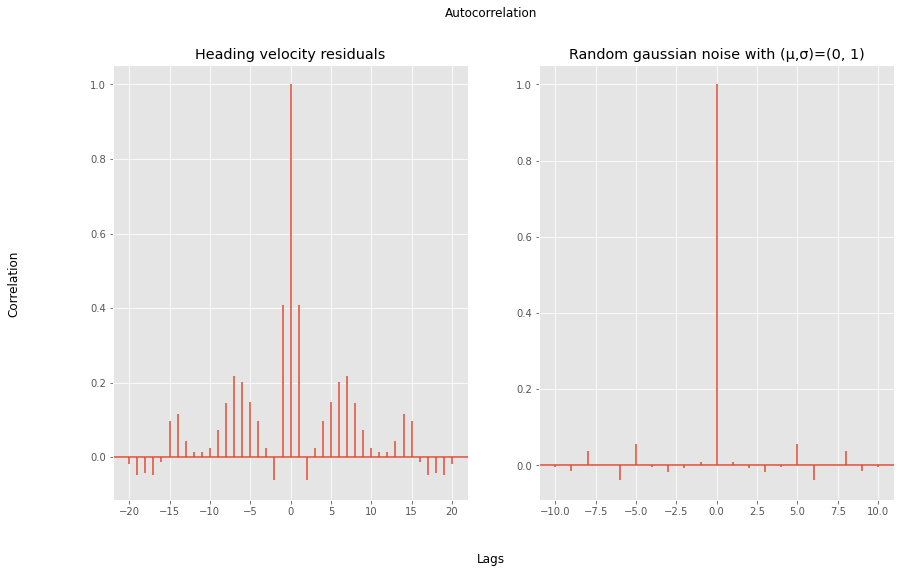

In [182]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8))

ax1.acorr(temp_dif, maxlags = 20)
noise = np.random.normal(0,1,len(temp_dif))
ax2.acorr(noise, maxlags = 10)

ax1.set_title("Heading velocity residuals") 
ax2.set_title(f"Random gaussian noise with (μ,σ)={0,1}")
fig.suptitle("Autocorrelation")
fig.supylabel("Correlation")
fig.supxlabel("Lags")

plt.grid(True) 
plt.show()

## Histograms

  1 / 104: ksone
  2 / 104: kstwo
  3 / 104: kstwobign
  4 / 104: norm
  5 / 104: alpha
  6 / 104: anglit
  7 / 104: arcsine
  8 / 104: beta
  9 / 104: betaprime
 10 / 104: bradford
 11 / 104: burr
 12 / 104: burr12
 13 / 104: fisk
 14 / 104: cauchy
 15 / 104: chi
 16 / 104: chi2
 17 / 104: cosine
 18 / 104: dgamma
 19 / 104: dweibull
 20 / 104: expon
 21 / 104: exponnorm
 22 / 104: exponweib
 23 / 104: exponpow
 24 / 104: fatiguelife
 25 / 104: foldcauchy
 26 / 104: f
 27 / 104: foldnorm
 28 / 104: weibull_min
 29 / 104: weibull_max
 30 / 104: genlogistic
 31 / 104: genpareto
 32 / 104: genexpon
 33 / 104: genextreme
 34 / 104: gamma
 35 / 104: erlang
 36 / 104: gengamma
 37 / 104: genhalflogistic
 38 / 104: genhyperbolic
 39 / 104: gompertz
 40 / 104: gumbel_r
 41 / 104: gumbel_l
 42 / 104: halfcauchy
 43 / 104: halflogistic
 44 / 104: halfnorm
 45 / 104: hypsecant
 46 / 104: gausshyper
 47 / 104: invgamma
 48 / 104: invgauss
 49 / 104: geninvgauss
 50 / 104: norminvgauss
 51 / 104: 

Text(0, 0.5, 'Frequency')

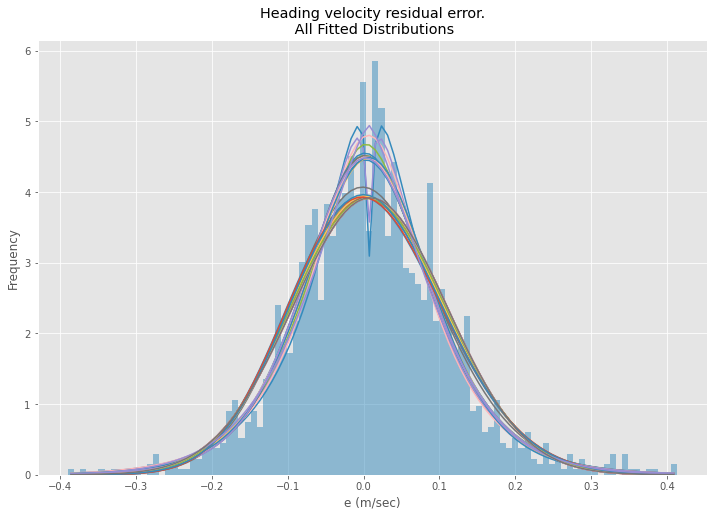

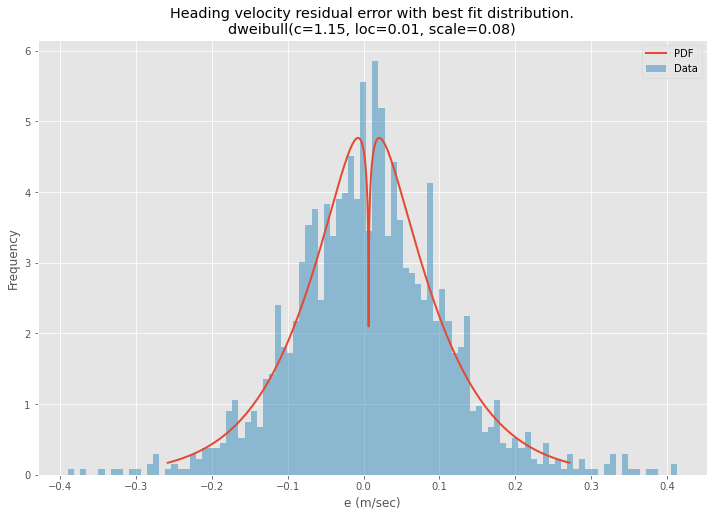

In [98]:
# Load data from statsmodels datasets
data = pd.Series(temp_dif)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=100, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distributions = best_fit_distribution(data, 100, ax)
print("The 15 best distribution fits: \n", [x[0].name for x in best_distributions[0:15]])
best_dist = best_distributions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Heading velocity residual error.\n All Fitted Distributions')
ax.set_xlabel(u'e (m/sec)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=100, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Heading velocity residual error with best fit distribution.\n' + dist_str)
ax.set_xlabel(u'e (m/sec)')
ax.set_ylabel('Frequency')

In [99]:
# burr, fisk, mielke, genlogistic cannot be used because they require x>=0
# dweibull seem like it is overfitting the data

# we can try : nct, johnsonsu, norminvgauss, genhyperbolic, t

In [100]:
# Get histogram of original data
y, x = np.histogram(temp_dif, bins=100, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
# Calculate fitted PDF and error with fit in distribution
dist_list = best_distributions[0:15]
for distribution_info in dist_list:
    distribution = distribution_info[0]
    params = distribution_info[1]
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
#     print(params)
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(y - pdf, 2.0))

    print(f"SSE of {distribution.name} distribution : {sse}")

SSE of dweibull distribution : 14.875776310325167
SSE of nct distribution : 14.921629276063959
SSE of fisk distribution : 14.922393927139977
SSE of mielke distribution : 14.922674433290357
SSE of burr distribution : 14.922713549609387
SSE of johnsonsu distribution : 14.927852988496321
SSE of burr12 distribution : 14.939140259684727
SSE of genlogistic distribution : 14.947519201738263
SSE of norminvgauss distribution : 14.955039450196125
SSE of genhyperbolic distribution : 14.9998432753635
SSE of t distribution : 15.059265446683204
SSE of logistic distribution : 15.08656389927273
SSE of gennorm distribution : 15.270436323568894
SSE of hypsecant distribution : 15.912894862559202
SSE of dgamma distribution : 16.6820783177508


normal parameters: (0.008440058269720194, 0.10176829123717653)
t' parameters: (6.652259949237751, 0.006790057239769292, 0.08555516117623328)
Burr parameters: (30.034521953908776, 0.9418849495079553, -1.6324826268198018, 1.6431460218401834)
NCT parameters: (6.791161258570356, 0.32951910832880793, -0.023409857322922688, 0.08545042592129086)
johnsonsu parameters: (-0.2071261976758609, 1.9170190797831006, -0.012487795200922478, 0.16854103328165804)
norminvgauss parameters: (2.1081511541084046, 0.2147615053836462, -0.006582669751818298, 0.14669613310012514)
genhyperbolic parameters: (2.476678333311629, 0.0002097513899043365, 8.244320619297063e-06, -0.0004365510181723569, 9.553179580888102e-06)
logistic parameters: (0.006917025540369637, 0.055760526430144224)


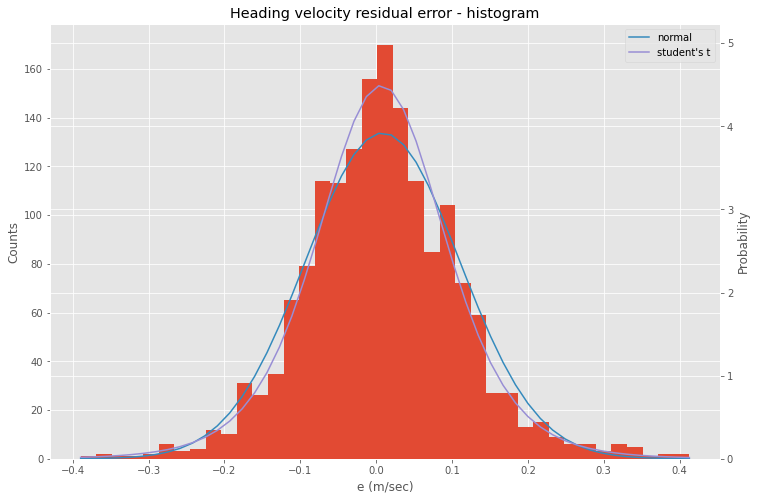

In [101]:
# get x,y
y, _ = np.histogram(temp_dif, bins=10, density=True)

# plot the residuals distribution as a histogram and some fitted probability distributions
x = np.linspace(min(temp_dif), max(temp_dif))

# normal distribution
mean_fit, std_fit = st.norm.fit(temp_dif)
print(f"normal parameters: {mean_fit, std_fit}")
            
# student's t distribution
# df = 5
df1, loc1, scale1 = st.t.fit(temp_dif)
print(f"t' parameters: {df1, loc1, scale1}")

# burr distribution
c2, d2, loc2, scale2 = st.burr.fit(temp_dif)
print(f"Burr parameters: {c2, d2, loc2, scale2}")

# nct distribution
df3, nc3, loc3, scale3 = st.nct.fit(temp_dif)
print(f"NCT parameters: {df3, nc3, loc3, scale3}")

# johnsonsu distribution
a4, b4, loc4, scale4 = st.johnsonsu.fit(temp_dif)
print(f"johnsonsu parameters: {a4, b4, loc4, scale4}")

# norminvgauss distribution
a5, b5, loc5, scale5 = st.norminvgauss.fit(temp_dif)
print(f"norminvgauss parameters: {a5, b5, loc5, scale5}")

# genhyperbolic distribution
p6, a6, b6, loc6, scale6 = st.genhyperbolic.fit(temp_dif)
print(f"genhyperbolic parameters: {p6, a6, b6, loc6, scale6}")

# logistic distribution
loc7, scale7 = st.logistic.fit(temp_dif)
print(f"logistic parameters: {loc7, scale7}")

fig, ax = plt.subplots(figsize=(12,8))
ax2 = ax.twinx()

# plot histograms
ax2.hist(temp_dif, density=True, bins='auto')  # density=False would make counts
ax.hist(temp_dif, density=False, bins='auto')  # density=False would make counts

# plot PDFs
norm_pdf = st.norm.pdf(x, mean_fit, std_fit)
ax2.plot(x, norm_pdf, label='normal') # normal

t_pdf = st.t.pdf(x, df1, loc1, scale1)
ax2.plot(x, t_pdf, label='student\'s t') # student's

# rv = st.burr(c2, d2, loc2, scale2)
# burr_pdf = rv.pdf(x)
# ax2.plot(x, burr_pdf, label='burr') # burr

# nct = st.nct(df3, nc3, loc3, scale3)
# nct_pdf = nct.pdf(x)
# ax2.plot(x, nct_pdf, label='nct') # nct

# johnsonsu = st.johnsonsu(a4, b4, loc4, scale4)
# johnsonsu_pdf = johnsonsu.pdf(x)
# ax2.plot(x, johnsonsu_pdf, label='johnsonsu') # johnsonsu

# norminvgauss = st.norminvgauss(a5, b5, loc5, scale5)
# norminvgauss_pdf = norminvgauss.pdf(x)
# ax2.plot(x, norminvgauss_pdf, label='norminvgauss') # norminvgauss

# genhyperbolic = st.genhyperbolic(p6, a6, b6, loc6, scale6)
# genhyperbolic_pdf = genhyperbolic.pdf(x)
# ax2.plot(x, genhyperbolic_pdf, label='logistic') # genhyperbolic

# logistic = st.logistic(loc7, scale7)
# logistic_pdf = logistic.pdf(x)
# ax2.plot(x, logistic_pdf, label='genhyperbolic') # genhyperbolic

plt.title('Heading velocity residual error - histogram')
ax2.set_ylabel('Probability')
ax.set_ylabel('Counts')
ax.set_xlabel('e (m/sec)')
ax2.legend()
plt.show()

In [102]:
# # plot different burr pdfs to inspect their behavor as their parameters c,d change

# fig, axs = plt.subplots(2, figsize=(8,8))

# x = np.linspace(min(temp_dif), max(temp_dif))
# for c_ in [0.1, 0.5, 1, 5, 10, 20, 30]:
#     rv = st.burr(c_, d, loc2, scale2)
#     axs[0].plot(x, rv.pdf(x), label=f'c = {c_}, d = {d}') # burr

# for d_ in [0.1, 0.5, 1, 5, 10, 20, 50]:
#     rv = st.burr(c, d_, loc2, scale2)
#     axs[1].plot(x, rv.pdf(x), label=f'c = {c}, d = {d_}') # burr

# fig.suptitle('Burr Distributions with different parameters')
# axs[0].set_ylabel('Counts')
# axs[0].set_xlabel('e (m/sec)')
# axs[1].set_ylabel('Counts')
# axs[1].set_xlabel('e (m/sec)')
# axs[0].legend()
# axs[1].legend()
# plt.show()

In [103]:
# y = (temp_dif - loc2)/scale2
# print("For the Burr III distribution, the p.d.f. holds under the assumption that d, f > 0 and x >= 0")
# print(f"# of x<0 residuals: {np.sum(np.array(y) < 0, axis=0)}")

# fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(y)
# plt.title("residuals shifted and scaled")
# plt.show()

In [104]:
os.chdir(Path(project_root() / 'data'))
os.getcwd()

'/home/glob/Documents/github/thesis/data'

In [105]:
with open('velocity_residuals.npy', 'wb') as f:
    np.save(f, temp_dif)

### Kolmogorov–Smirnov test

In [106]:
# check the p-values of the distribution fits
dist = getattr(st, 'burr')
parameters = dist.fit(temp_dif)
print(f"Burr Distribution. # of samples: {len(temp_dif)}")
testres = st.kstest(temp_dif, "burr", parameters)
print(testres)

sigval = 1.36/(len(temp_dif)**2)
print(f"We want: {testres[1]} > {sigval}")

Burr Distribution. # of samples: 1658
KstestResult(statistic=0.014561994194556172, pvalue=0.86826596721198)
We want: 0.86826596721198 > 4.947318335198279e-07


In [107]:
# check the p-values of the distribution fits
dist = getattr(st, 'norm')
parameters = dist.fit(temp_dif)
print(f"Normal Distribution. # of samples: {len(temp_dif)}")
testres = st.kstest(temp_dif, "norm", parameters)
print(testres)

sigval = 1.36/(len(temp_dif)**2)
print(f"We want: {testres[1]} > {sigval}")

Normal Distribution. # of samples: 1658
KstestResult(statistic=0.03691190933844646, pvalue=0.0212744962818321)
We want: 0.0212744962818321 > 4.947318335198279e-07


In [108]:
# check the p-values of the distribution fits
dist = getattr(st, 't')
parameters = dist.fit(temp_dif)
print(f"Student's t distribution. # of samples: {len(temp_dif)}")
testres = st.kstest(temp_dif, "t", parameters)
print(testres)

sigval = 1.36/(len(temp_dif)**2)
print(f"We want: {testres[1]} > {sigval}")

Student's t distribution. # of samples: 1658
KstestResult(statistic=0.016190448115639078, pvalue=0.7711481717700455)
We want: 0.7711481717700455 > 4.947318335198279e-07


## Estimate the change in μ, σ when the gps signal is faulty/spoofed

In [165]:
# add fault to the gps to see how well it is detected
def add_gps_fault(t_gps, e_, t0, flag):
    e = copy.deepcopy(e_)
    e = np.array(e, dtype=float)
    # check what kind of flag we have
    if flag == 1:
        # small ramp
        m = 0.5
        s = 0.1
    elif flag == 2:
        # big ramp
        m = 5
        s = 0.1
    elif flag == 3:
        # gradual spoofing
        s = 0.1
    
    # add some noisy biases in the time windows [t0, t0+(window_size gps samples)] and keep the μ, σ
    k = 0
    window_size = 40
    sample = []
    ts = []
    for i, t in enumerate(t_gps):
        if t>=t0 and k<window_size:
            # if the fault is in ramp mode
            if flag == 1 or flag == 2:
                noise = np.random.normal(m, s, size=1)
            # if we have slowly increasing spoofing
            if flag == 3:
                m = k*0.02
                noise = np.random.normal(m, s, size=1)
                
            # add noise to the residual
            e[i] += noise
                
            # keep the residuals within the window
            sample.append(e[i])
            ts.append(t)
                
            k+=1

    return e, sample, ts

In [166]:
temp_dif_f1, w1, tw1 = add_gps_fault(tt_radar, temp_dif, 40, 1) # small ramp
temp_dif_f2, w2, tw2 = add_gps_fault(tt_radar, temp_dif, 40, 2) # big ramp
temp_dif_f3, w3, tw3 = add_gps_fault(tt_radar, temp_dif, 40, 3) # gradual spoofing

In [167]:
df1, loc1, scale1 = st.t.fit(temp_dif)
print(f"t' parameters: {df1, loc1, scale1}")
dfw1, locw1, scalew1 = st.t.fit(temp_dif_f1)
print(f"small ramp - t' parameters: {dfw1, locw1, scalew1}")
dfw2, locw2, scalew2 = st.t.fit(temp_dif_f2)
print(f"big ramp t -' parameters: {dfw2, locw2, scalew2}")
dfw3, locw3, scalew3 = st.t.fit(temp_dif_f3)
print(f"spoofing t -' parameters: {dfw3, locw3, scalew3}")

t' parameters: (6.652259949237751, 0.006790057239769292, 0.08555516117623328)
small ramp - t' parameters: (3.0068401724979408, 0.007753303648677266, 0.079223134547317)
big ramp t -' parameters: (1.5847710237916917, 0.005489197655863299, 0.06693886321034953)
spoofing t -' parameters: (3.443139994862938, 0.008047098459139927, 0.08041611130952168)


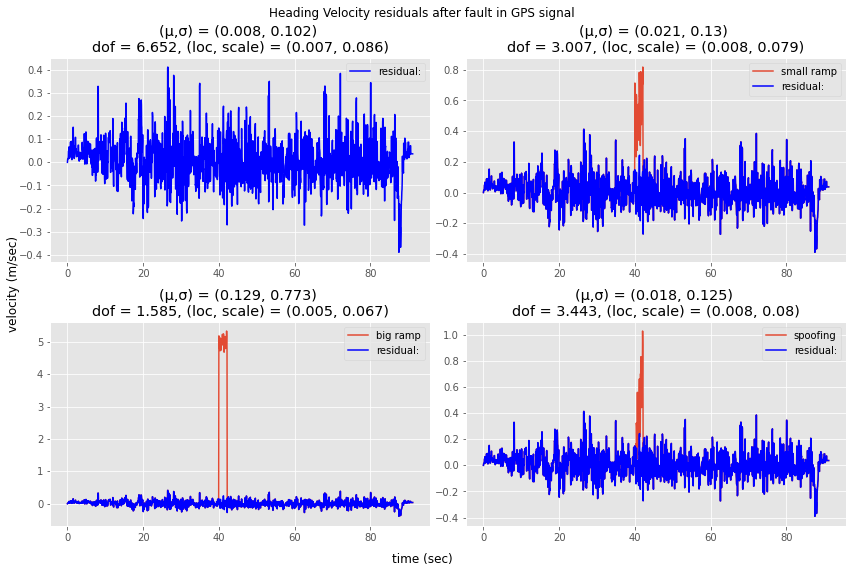

In [168]:
# print the total absolute position error, 
m = np.mean(temp_dif)
m1 = np.mean(temp_dif_f1)
m2 = np.mean(temp_dif_f2)
m3 = np.mean(temp_dif_f3)
s = np.std(temp_dif)
s1 = np.std(temp_dif_f1)
s2 = np.std(temp_dif_f2)
s3 = np.std(temp_dif_f3)

# plot the position error over time
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs[0,0].plot(tt_radar, temp_dif, 'b-', label="residual:")

axs[0,1].plot(tt_radar, temp_dif_f1, label="small ramp")
axs[0,1].plot(tt_radar, temp_dif, 'b-', label="residual:")

axs[1,0].plot(tt_radar, temp_dif_f2, label="big ramp")
axs[1,0].plot(tt_radar, temp_dif, 'b-', label="residual:")

axs[1,1].plot(tt_radar, temp_dif_f3, label="spoofing")
axs[1,1].plot(tt_radar, temp_dif, 'b-', label="residual:")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
for i in range(2):
    for j in range(2):
        axs[i,j].legend()
        
axs[0,0].set_title(f"(μ,σ) = {round(m,3), round(s,3)} \ndof = {round(df1,3)}, (loc, scale) = {round(loc1,3), round(scale1,3)}")
axs[0,1].set_title(f"(μ,σ) = {round(m1,3), round(s1,3)} \ndof = {round(dfw1,3)}, (loc, scale) = {round(locw1,3), round(scalew1,3)}")
axs[1,0].set_title(f"(μ,σ) = {round(m2,3), round(s2,3)} \ndof = {round(dfw2,3)}, (loc, scale) = {round(locw2,3), round(scalew2,3)}")
axs[1,1].set_title(f"(μ,σ) = {round(m3,3), round(s3,3)} \ndof = {round(dfw3,3)}, (loc, scale) = {round(locw3,3), round(scalew3,3)}")

fig.supxlabel("time (sec)")
fig.supylabel("velocity (m/sec)")
plt.suptitle("Heading Velocity residuals after fault in GPS signal")
plt.tight_layout(pad=0.8, w_pad=0.5, h_pad=1.0)
plt.show()

## Probability plots

In [108]:
%matplotlib notebook

<IPython.core.display.Javascript object>


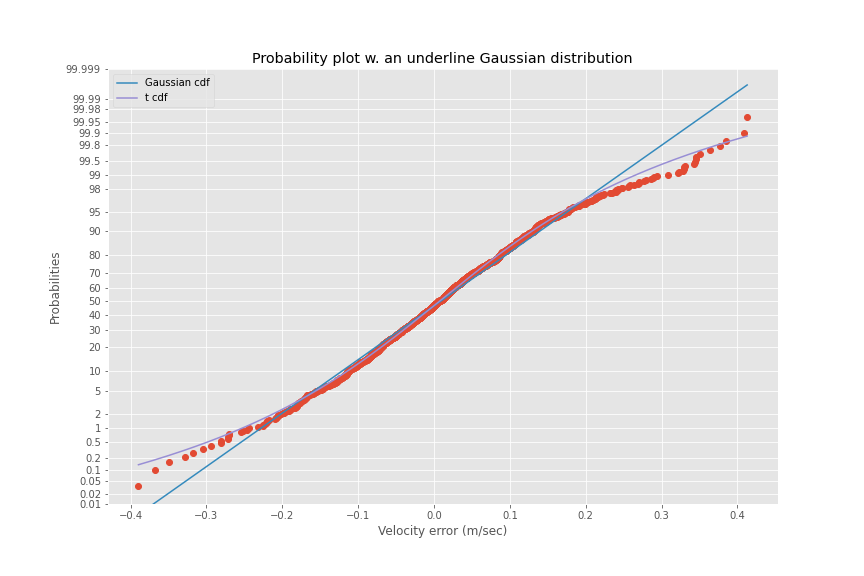

In [109]:
fig, ax = pyplot.subplots(figsize=(12, 8))
fig = probscale.probplot(temp_dif, ax=ax, plottype='prob', probax='y', bestfit=False,
                         problabel='Probabilities', datalabel='Velocity error (m/sec)')

x = np.linspace(min(temp_dif), max(temp_dif), 1000)
y = st.norm.cdf(x, mean_fit, std_fit)
ax.plot(x, y*100, label="Gaussian cdf")

y = st.t.cdf(x, df1, loc1, scale1)
ax.plot(x, y*100, label="t cdf")

# y = st.burr.cdf(x, c2, d2, loc2, scale2)
# ax.plot(x, y*100, label="burr cdf")

# y = st.nct.cdf(x, df3, nc3, loc3, scale3)
# ax.plot(x, y*100, label="nct cdf")

# y = st.johnsonsu.cdf(x, a4, b4, loc4, scale4)
# ax.plot(x, y*100, label="johnsonsu cdf")

# y = st.norminvgauss.cdf(x, a5, b5, loc5, scale5)
# ax.plot(x, y*100, label="norminvgauss cdf")

# y = st.genhyperbolic.cdf(x, p6, a6, b6, loc6, scale6)
# ax.plot(x, y*100, label="genhyperbolic cdf")

# y = st.logistic.cdf(x, loc7, scale7)
# ax.plot(x, y*100, label="logistic cdf")

ax.set_title("Probability plot w. an underline Gaussian distribution")
ax.legend(loc='upper left')
ax.set_ylim(bottom=0.01, top=99.999)
seaborn.despine()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


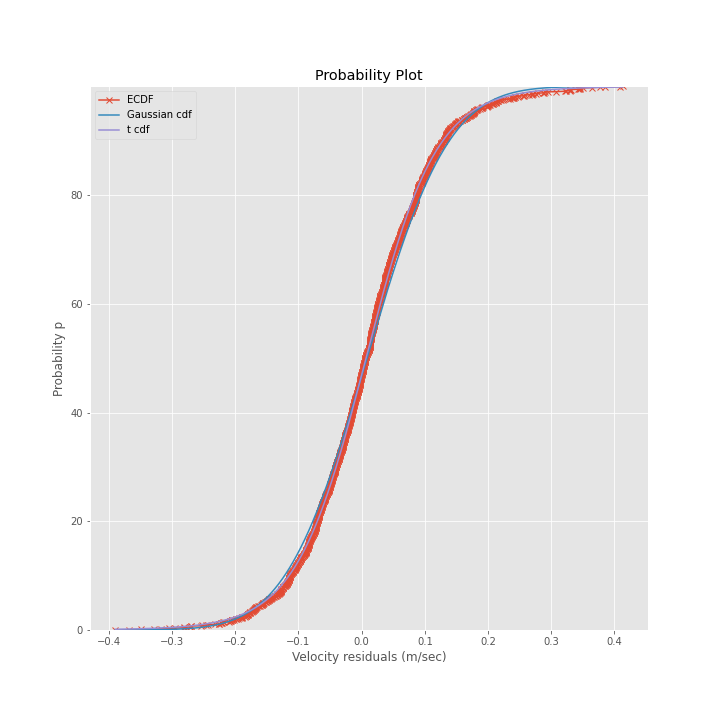

In [110]:
# calculate the proportional values of samples
fig, ax = plt.subplots(figsize=(10,10))

x = np.linspace(min(temp_dif), max(temp_dif), 1000)
# x = np.linspace(-25, 25, 5000)
data_sorted = np.sort(temp_dif)

p = 1. * np.arange(len(temp_dif)) / (len(temp_dif) - 1)
ax.plot(data_sorted, p*100, '-x', label="ECDF")

y = st.norm.cdf(x, mean_fit, std_fit)
ax.plot(x, y*100, label="Gaussian cdf")

y = st.t.cdf(x, df1, loc1, scale1)
ax.plot(x, y*100, label="t cdf")

# y = st.burr.cdf(x, c2, d2, loc2, scale2)
# ax.plot(x, y*100, label="Burr cdf")

ax.set_ylim(bottom=0, top=99.99)
plt.title("Probability Plot")
plt.ylabel("Probability p")
plt.xlabel("Velocity residuals (m/sec)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


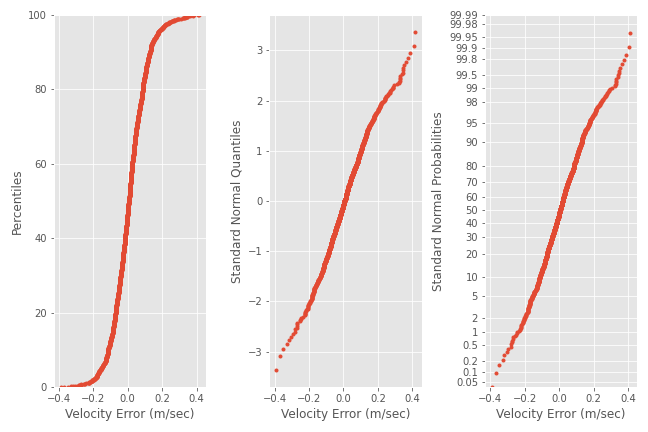

In [111]:
from functools import partial

# PROBABILITY PLOT - we are interested in the tails, since we are talking about error
fig, (ax1, ax2, ax3) = pyplot.subplots(figsize=(9, 6), ncols=3, sharex=True)
common_opts = dict(
    probax='y',
#     datascale='log',
    datalabel='Velocity Error (m/sec)',
    scatter_kws=dict(marker='.', linestyle='none')
)

fig = probscale.probplot(temp_dif, ax=ax1, plottype='pp',
                         problabel='Percentiles',  **common_opts)

fig = probscale.probplot(temp_dif, ax=ax2, plottype='qq',
                         problabel='Standard Normal Quantiles',  **common_opts)

fig = probscale.probplot(temp_dif, ax=ax3, plottype='prob',
                         problabel='Standard Normal Probabilities',  **common_opts)

ax3.set_ylim(bottom=0, top=99.99)
fig.tight_layout()
plt.show()

## Angular Rate residuals (IMU vs Radar)

<IPython.core.display.Javascript object>


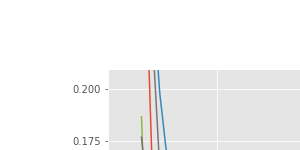

  1 / 104: ksone
  2 / 104: kstwo
  3 / 104: kstwobign
  4 / 104: norm
  5 / 104: alpha
  6 / 104: anglit
  7 / 104: arcsine
  8 / 104: beta
  9 / 104: betaprime
 10 / 104: bradford
 11 / 104: burr
 12 / 104: burr12
 13 / 104: fisk
 14 / 104: cauchy
 15 / 104: chi
 16 / 104: chi2
 17 / 104: cosine
 18 / 104: dgamma
 19 / 104: dweibull
 20 / 104: expon
 21 / 104: exponnorm
 22 / 104: exponweib
 23 / 104: exponpow
 24 / 104: fatiguelife
 25 / 104: foldcauchy
 26 / 104: f
 27 / 104: foldnorm
 28 / 104: weibull_min
 29 / 104: weibull_max
 30 / 104: genlogistic
 31 / 104: genpareto
 32 / 104: genexpon
 33 / 104: genextreme
 34 / 104: gamma
 35 / 104: erlang
 36 / 104: gengamma
 37 / 104: genhalflogistic
 38 / 104: genhyperbolic
 39 / 104: gompertz
 40 / 104: gumbel_r
 41 / 104: gumbel_l
 42 / 104: halfcauchy
 43 / 104: halflogistic
 44 / 104: halfnorm
 45 / 104: hypsecant
 46 / 104: gausshyper
 47 / 104: invgamma
 48 / 104: invgauss
 49 / 104: geninvgauss
 50 / 104: norminvgauss
 51 / 104: 

<IPython.core.display.Javascript object>


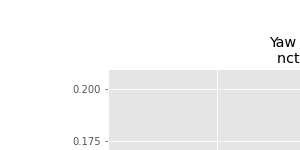

Text(0, 0.5, 'Frequency')

In [112]:
# Load data from statsmodels datasets
data = pd.Series(yaw_dif)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=100, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distributions = best_fit_distribution(data, 100, ax)
best_dist = best_distributions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Yaw Rate residual error.\n All Fitted Distributions')
ax.set_xlabel(u'e (m/sec)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=100, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Yaw Rate residual error with best fit distribution.\n' + dist_str)
ax.set_xlabel(u'e (deg/sec)')
ax.set_ylabel('Frequency')

<IPython.core.display.Javascript object>


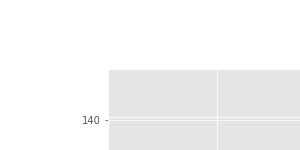

In [113]:
# plot the residuals distribution as a histogram and some fitted probability distributions
x = np.linspace(min(yaw_dif), max(yaw_dif))

# normal distribution
[mean_fit, std_fit] = st.norm.fit(yaw_dif)

# student's t distribution
df = 30
shape, loc1, scale1 = st.t.fit(yaw_dif)

# # logistic distribution
# loc2, scale2 = st.logistic.fit(yaw_dif)

fig, ax = plt.subplots(figsize = (12,8))
ax2 = ax.twinx()

ax2.hist(yaw_dif, density=True, bins='auto')  # density=False would make counts
ax.hist(yaw_dif, density=False, bins='auto')  # density=False would make counts
ax2.plot(x, st.norm.pdf(x, mean_fit, std_fit), label='normal') # normal
ax2.plot(x, st.t.pdf(x, df, loc2, scale1), label='student\'s t') # student's
# ax2.plot(x, st.logistic.pdf(x, loc2, scale2), label='logistic') # logistic

plt.title('Yaw Rate residual error')
ax2.set_ylabel('Probability')
ax.set_ylabel('Counts')
ax.set_xlabel('e (degrees/sec)')
ax2.legend()
plt.show()

We cannot utilize the above, as turns would result in a very big GLRT g value, which would indicate an error, when there isn't one. On top of that, we don't know how different turns affect the yaw_rate computation of the radar odometry algorithm.

Statistically, that means that the more turns we'd have, the wider the distribution would be, whereas no turns at all, would result on a distribution with very small variance.

# The End